In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True) # for Test : /content/drive/MyDrive/Go_Project/G0_Images/EmptyBoard/images/train/EmtryBoard11.JPG

Mounted at /content/drive


In [2]:
# clone the repo in order to access pre-defined configs in PointRend project
!git clone --branch v0.4 https://github.com/facebookresearch/detectron2.git detectron2_repo
# install detectron2 from source
!pip install -e detectron2_repo
# See https://detectron2.readthedocs.io/tutorials/install.html for other installation options

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 13485, done.
remote: Counting objects: 100% (986/986), done.
remote: Compressing objects: 100% (502/502), done.
remote: Total 13485 (delta 622), reused 772 (delta 477), pack-reused 12499
Receiving objects: 100% (13485/13485), 5.77 MiB | 19.36 MiB/s, done.
Resolving deltas: 100% (9582/9582), done.
Note: checking out '4aca4bdaa9ad48b8e91d7520e0d0815bb8ca0fb1'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

Obtaining file:///content/detectron2_repo
     |████████████████████████████████| 47 kB 2.9 MB/s 
     |████████████████████████████████| 74 kB 871 kB/s 
     |████████████

In [1]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import torch
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
#coco_metadata = MetadataCatalog.get("coco_2017_val")

# import PointRend project
from detectron2.projects import point_rend

In [2]:
train_path = "/content/drive/MyDrive/Go_Project/G0_Images/BoardImg/train"
val_path = "/content/drive/MyDrive/Go_Project/G0_Images/BoardImg/val"
output_path = "/content/drive/MyDrive/Go_Project/G0_Images/BoardImg"
annotation_path  = "/content/drive/MyDrive/Go_Project/G0_Images/BoardImg"


In [3]:
def  getBoarddicts(directory): # custom data format #  list [dict] --> [{} ,{} ,...{} ]

    classes = ['Board'] #set class
    dataset_dicts = []

    id = 0 
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {} 
        record["image_id"] = id
        record["file_name"] = os.path.join(directory , img_anns["imagePath"])
        record["height"] =  img_anns["imageHeight"]
        record["width"] = img_anns["imageWidth"]
        record["annotations"] = []
        shapes = img_anns["shapes"]

        objs = [ ]

        keypoint = [ ]
        obj = { }
        obj['bbox_mode'] =  BoxMode.XYXY_ABS
        obj['iscrowd'] = 0 
        #obj["keypoints"] = [ [ ] , [ ] , [ ], [ ] ] # use for index : TL TR DR DL
        
        for i in shapes :
          keypoint = [ ]
   
          if i ['shape_type'] == 'polygon':
            px =  [j[0] for j in  i['points'] ]
            py =  [j[1] for j in  i['points'] ]
            poly = [(x, y) for x, y in zip (px, py)]
            poly = [p for x in poly for p in x] # flatten : x1,y1,.... ,xn ,yn
            obj['bbox'] =  [ np.min(px) , np.min(py) , np.max(px) , np.max(py) ]
            obj['category_id'] = classes.index( i['label']) 
            obj["segmentation"] = [poly]

        record["annotations"].append(obj)
             
        dataset_dicts.append(record)
        id = id+1
    return dataset_dicts

In [4]:
dataset_dicts_train = getBoarddicts (annotation_path +"/train")

In [5]:
dataset_dicts_val = getBoarddicts (annotation_path +"/val")

In [6]:
from detectron2.data import DatasetCatalog, MetadataCatalog

for i in ["train", "val"]: # train ,test
    DatasetCatalog.register("Board_" + i, lambda i=i:  getBoarddicts(annotation_path +"/"+ i) )
    MetadataCatalog.get("Board_" + i).set( thing_classes=['Board']  ) # set (obj)

board_metadata = MetadataCatalog.get("Board_train")

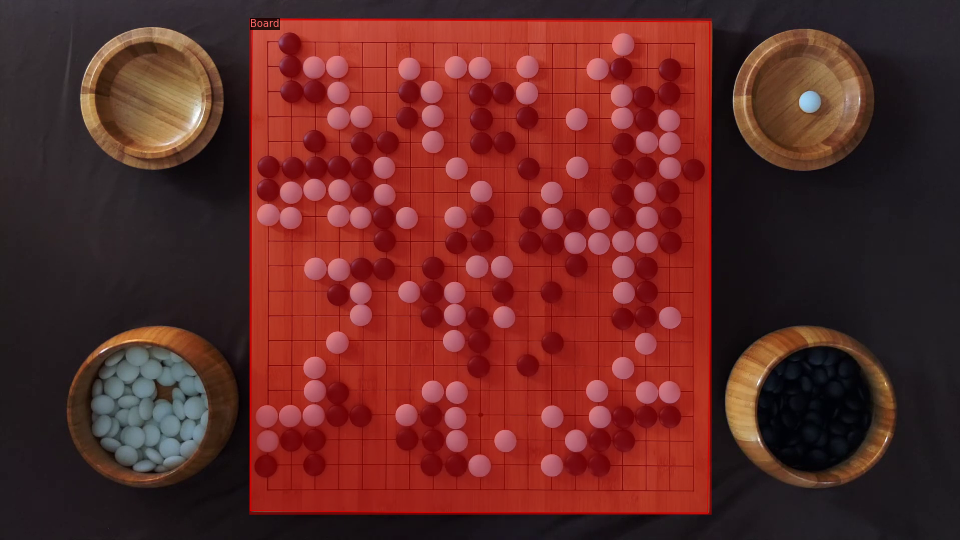

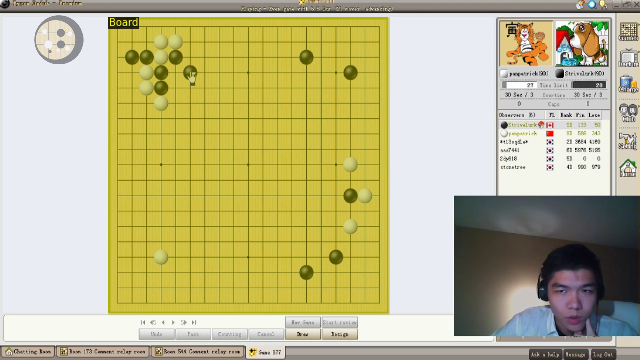

In [7]:
for d in random.sample(dataset_dicts_train, 2):
    img = cv2.imread(d["file_name"]) 
    visualizer = Visualizer(img[:, :, ::-1], metadata=board_metadata, scale=0.5)  #[:, :, ::-1] = BGR To RGB
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [8]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
# Add PointRend-specific config
point_rend.add_pointrend_config(cfg)

# Load a config from file
cfg.merge_from_file("detectron2_repo/projects/PointRend/configs/InstanceSegmentation/pointrend_rcnn_R_50_FPN_3x_coco.yaml")
#cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.DATASETS.TRAIN = ("Board_train",)  # that register
#cfg.DATASETS.TEST = ("Board_val",)
cfg.DATALOADER.NUM_WORKERS = 2

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0001  # pick a good LR
cfg.SOLVER.MAX_ITER = 2000   # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 10   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class
cfg.MODEL.POINT_HEAD.NUM_CLASSES = cfg.MODEL.ROI_HEADS.NUM_CLASSES 
# Use a model from PointRend model zoo: https://github.com/facebookresearch/detectron2/tree/master/projects/PointRend#pretrained-models
#cfg.MODEL.WEIGHTS = "detectron2://PointRend/InstanceSegmentation/pointrend_rcnn_R_50_FPN_3x_coco/164955410/model_final_edd263.pkl"
#os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
#trainer = DefaultTrainer(cfg) 
#trainer.resume_or_load(resume=False)
#trainer.train()

In [9]:
output_path = "/content/drive/MyDrive/Go_Project/G0_Images/BoardImg/output"
model_path = output_path +"/model_final.pth"

In [10]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR,model_path)  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold 
predictor = DefaultPredictor(cfg)

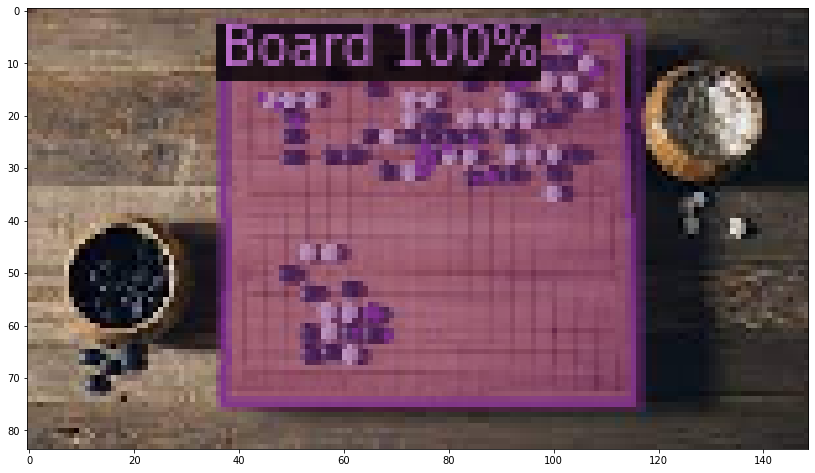

In [24]:
from detectron2.utils.visualizer import ColorMode
import matplotlib.pyplot as plt 
#dataset_dicts_val = getBoarddicts(annotation_path+"/val") /content/drive/MyDrive/Go_Project/G0_Images/BoardImg/test_บทบัง.png
dataset_dicts_val = getBoarddicts(annotation_path+"/val")
#for d in dataset_dicts_val :    
#for d in random.sample(dataset_dicts_val, 1):    
for d in range(1):   
  
    im = cv2.imread("/content/drive/MyDrive/Go_Project/G0_Images/BoardImg/8.jpg")
   # im = cv2.resize(im, (im.shape[0] * 5, im.shape[1] * 5))
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    v = Visualizer(im[:, :, ::-1],
                   metadata=board_metadata, 
                   scale=0.5, 
                 #  instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )

    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

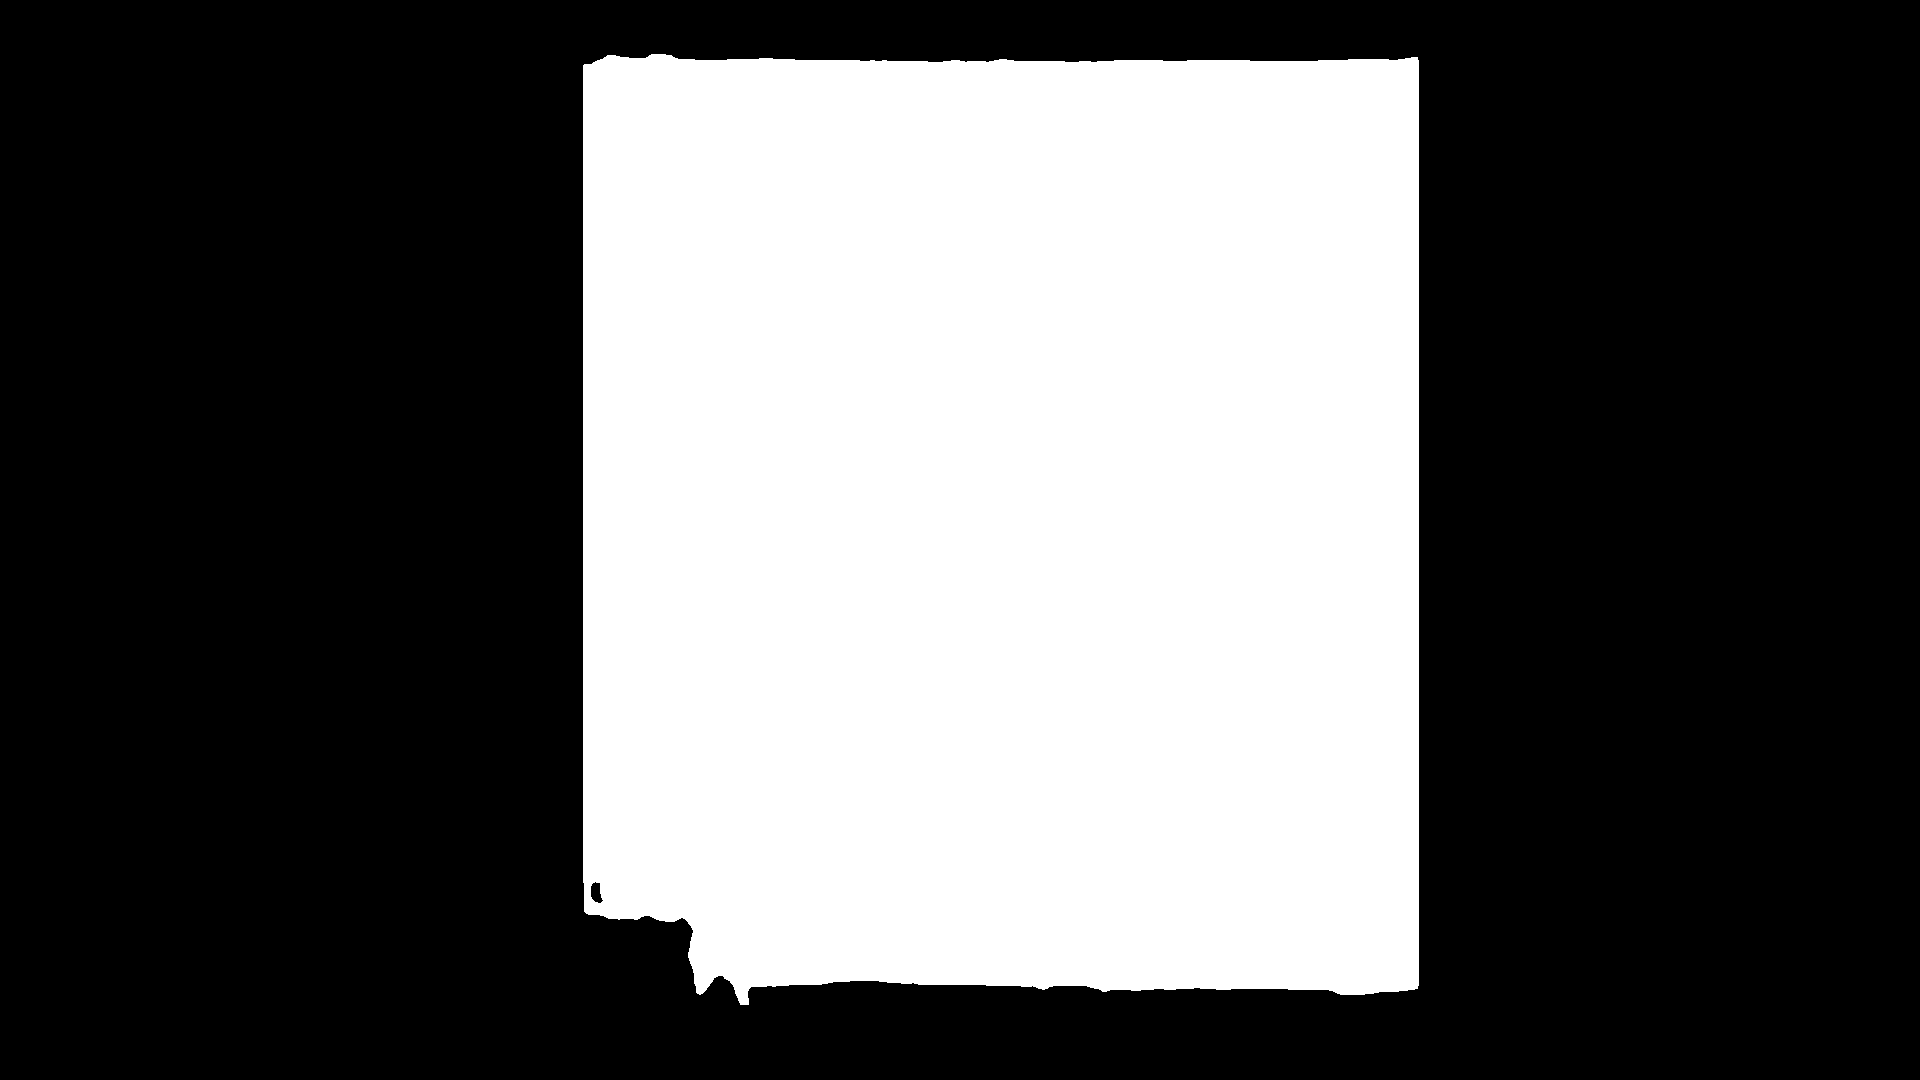

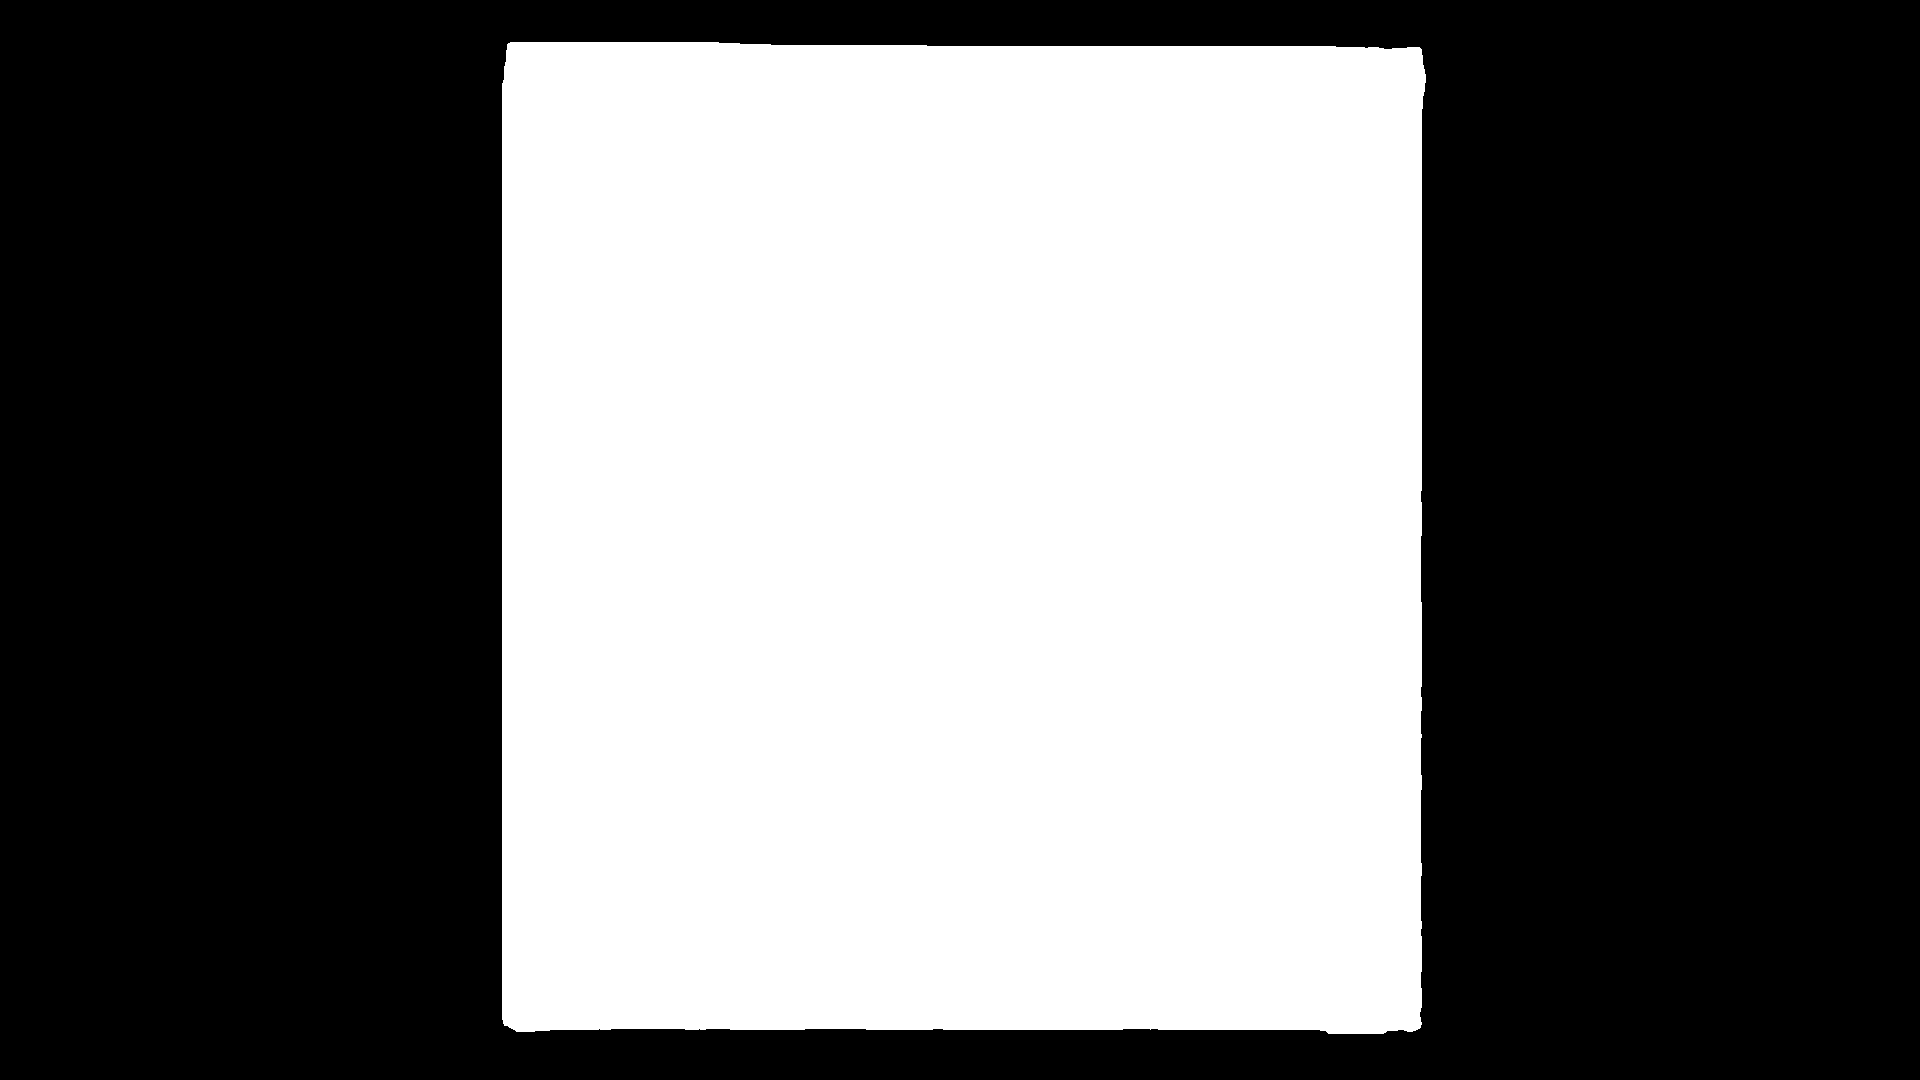

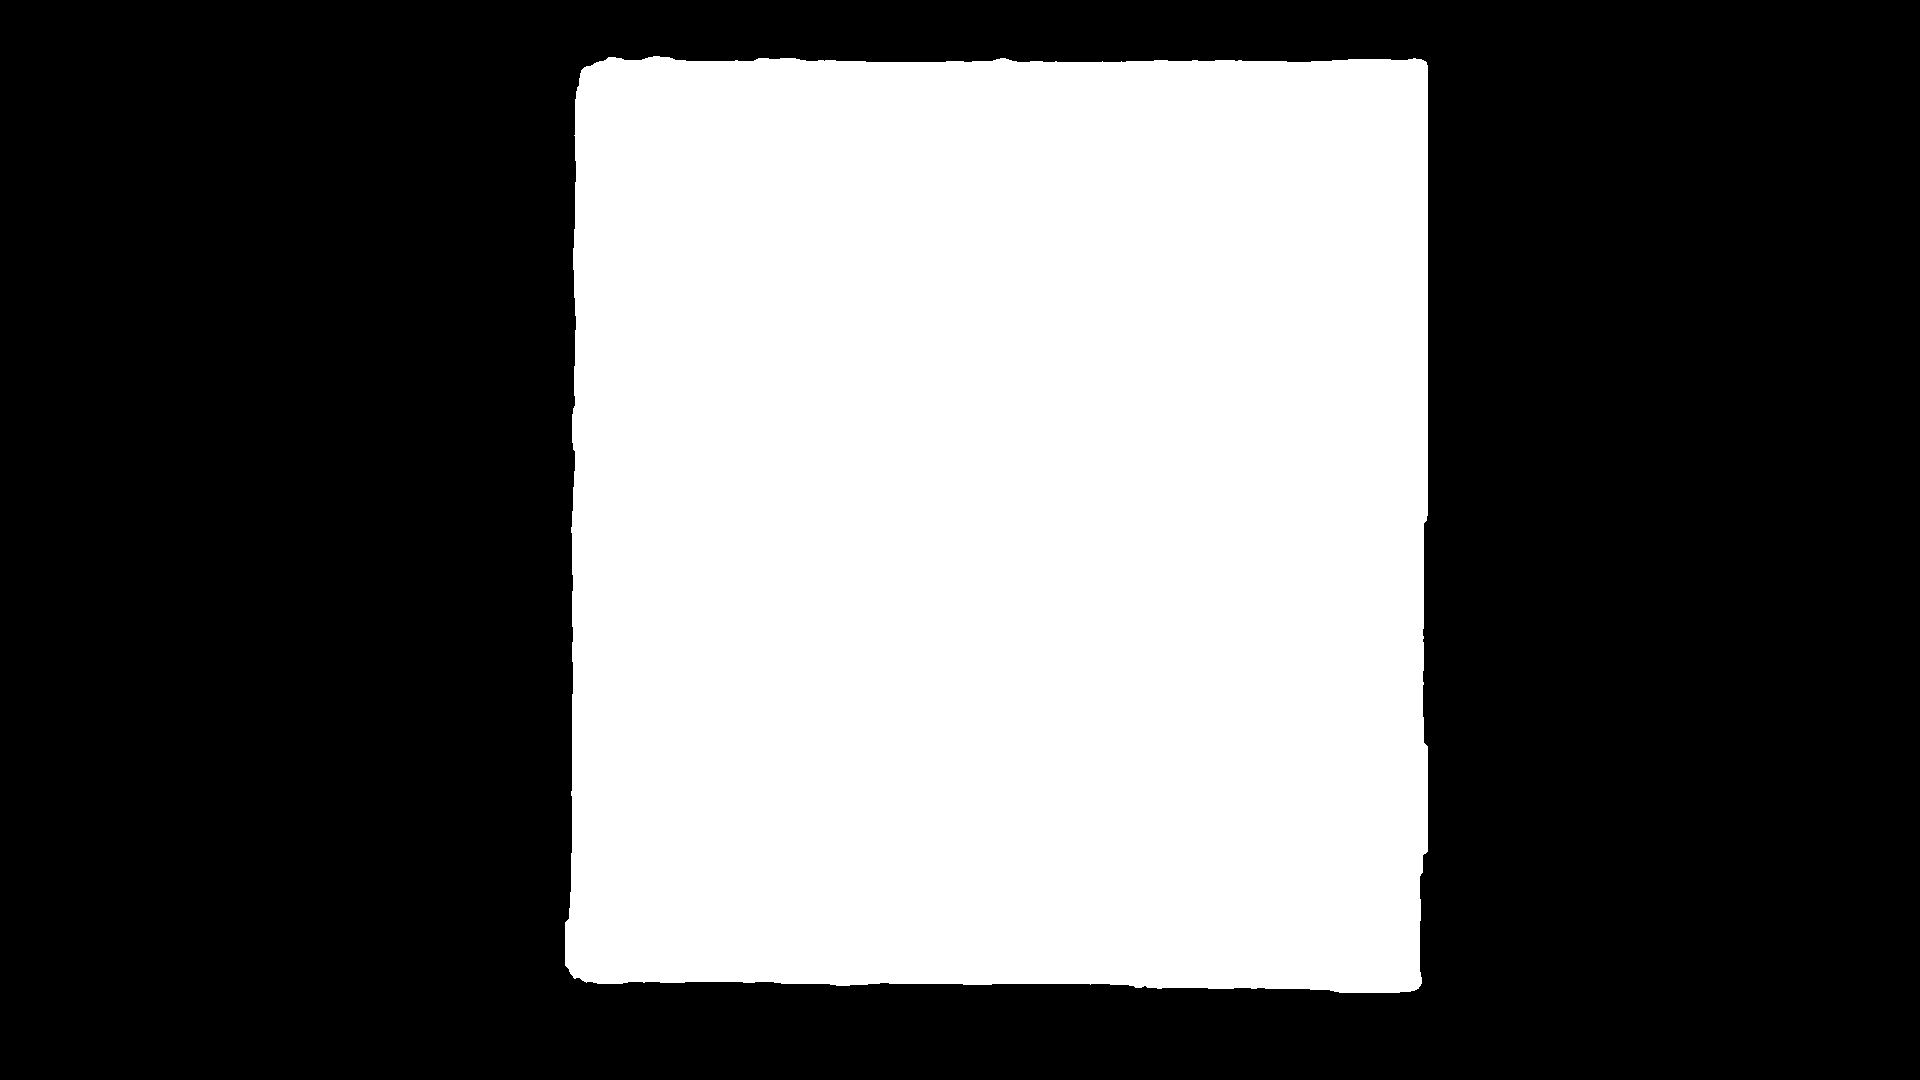

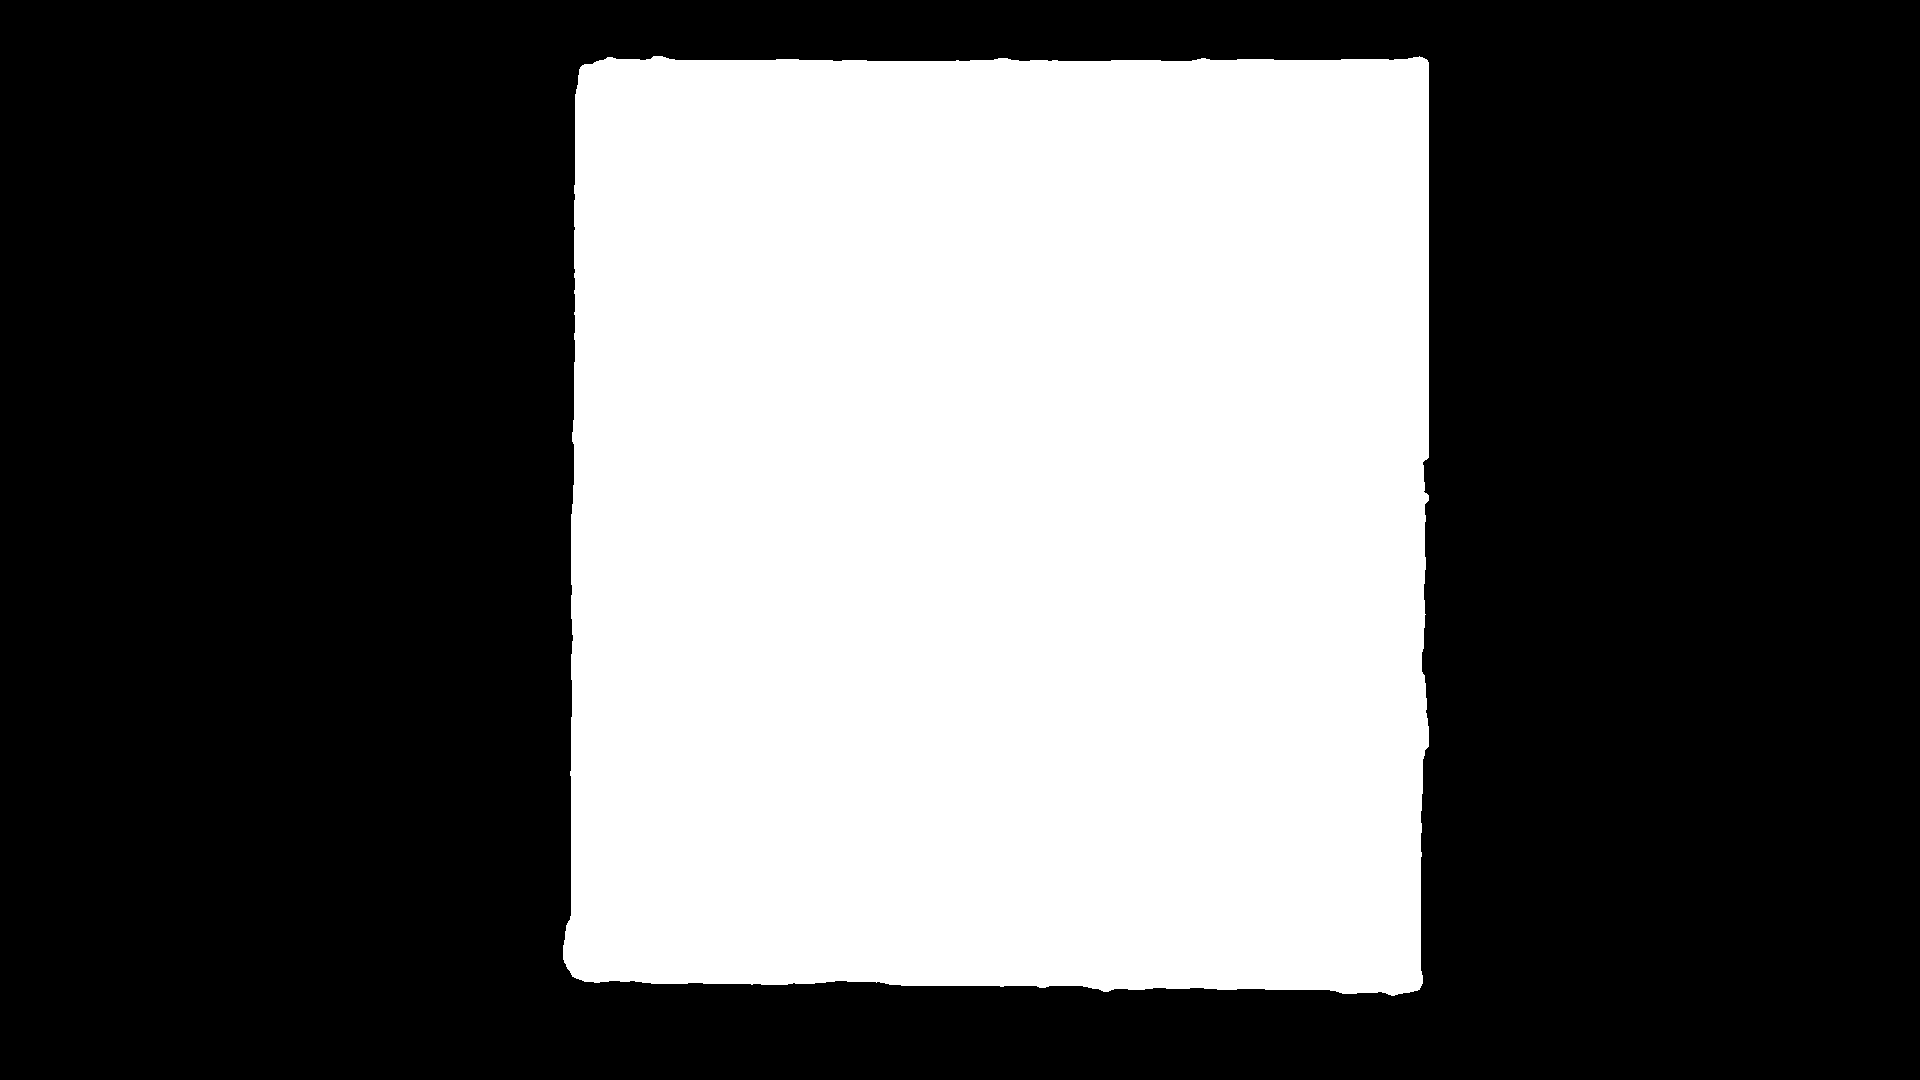

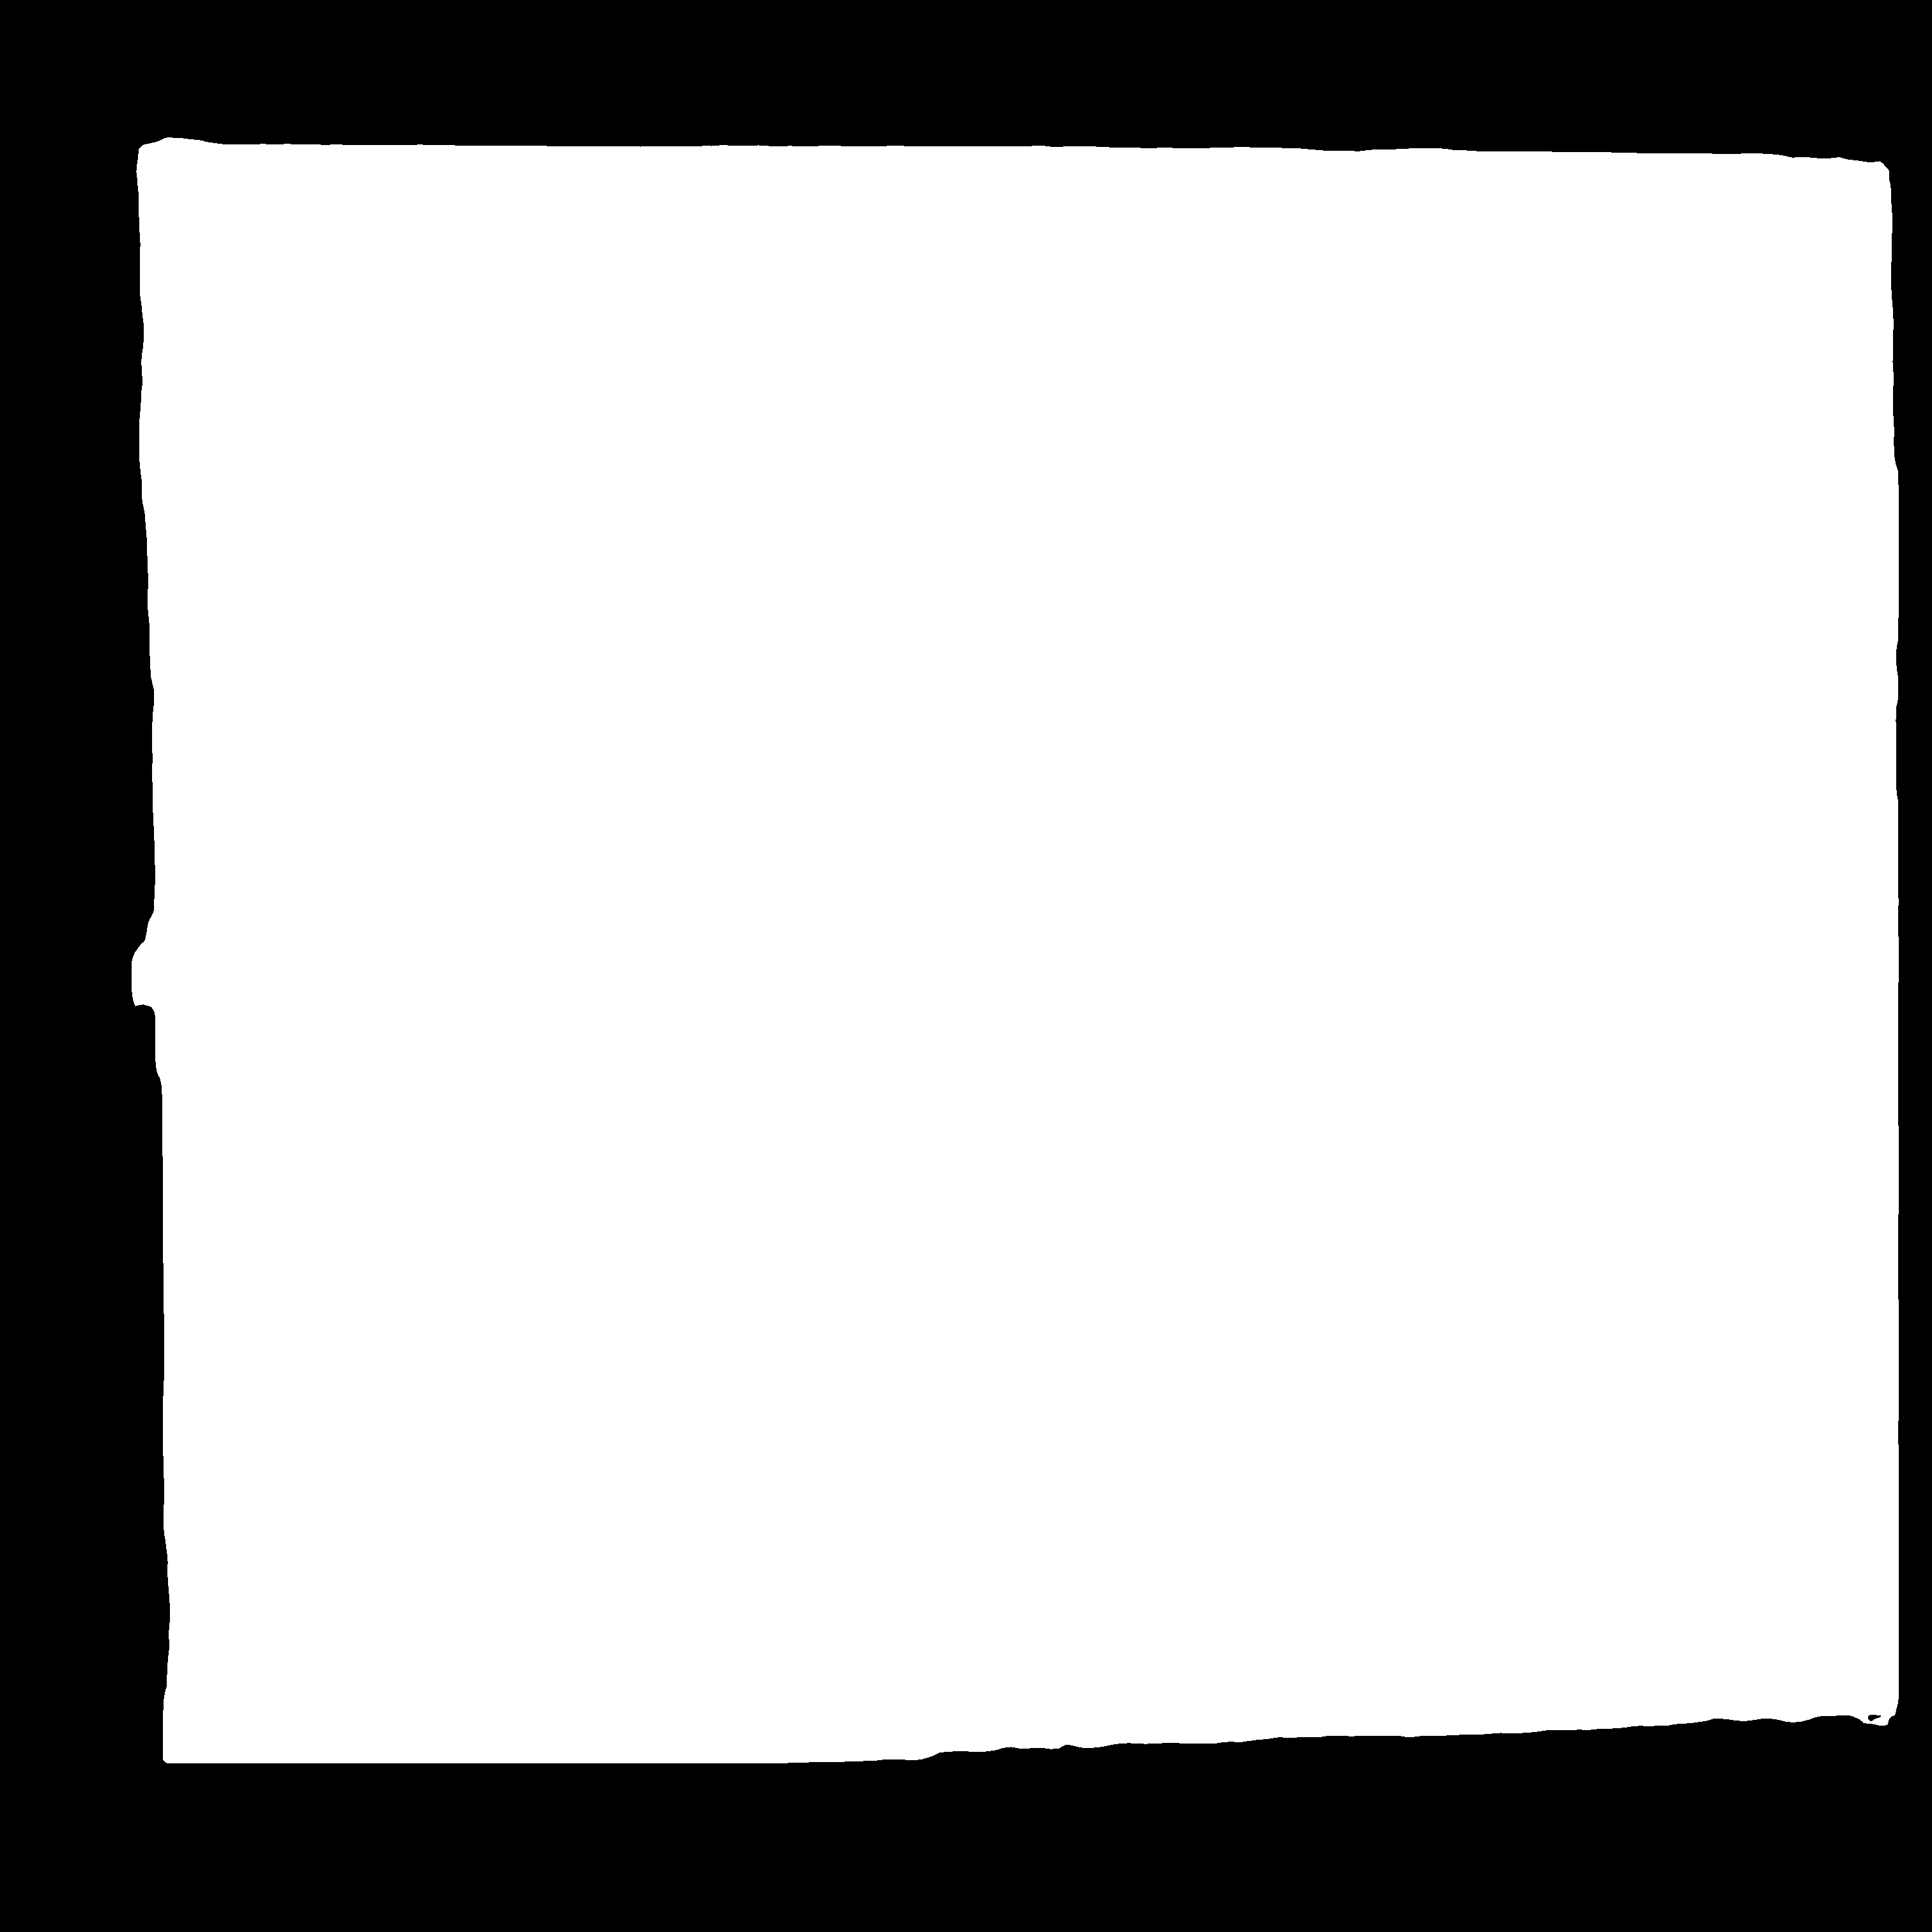

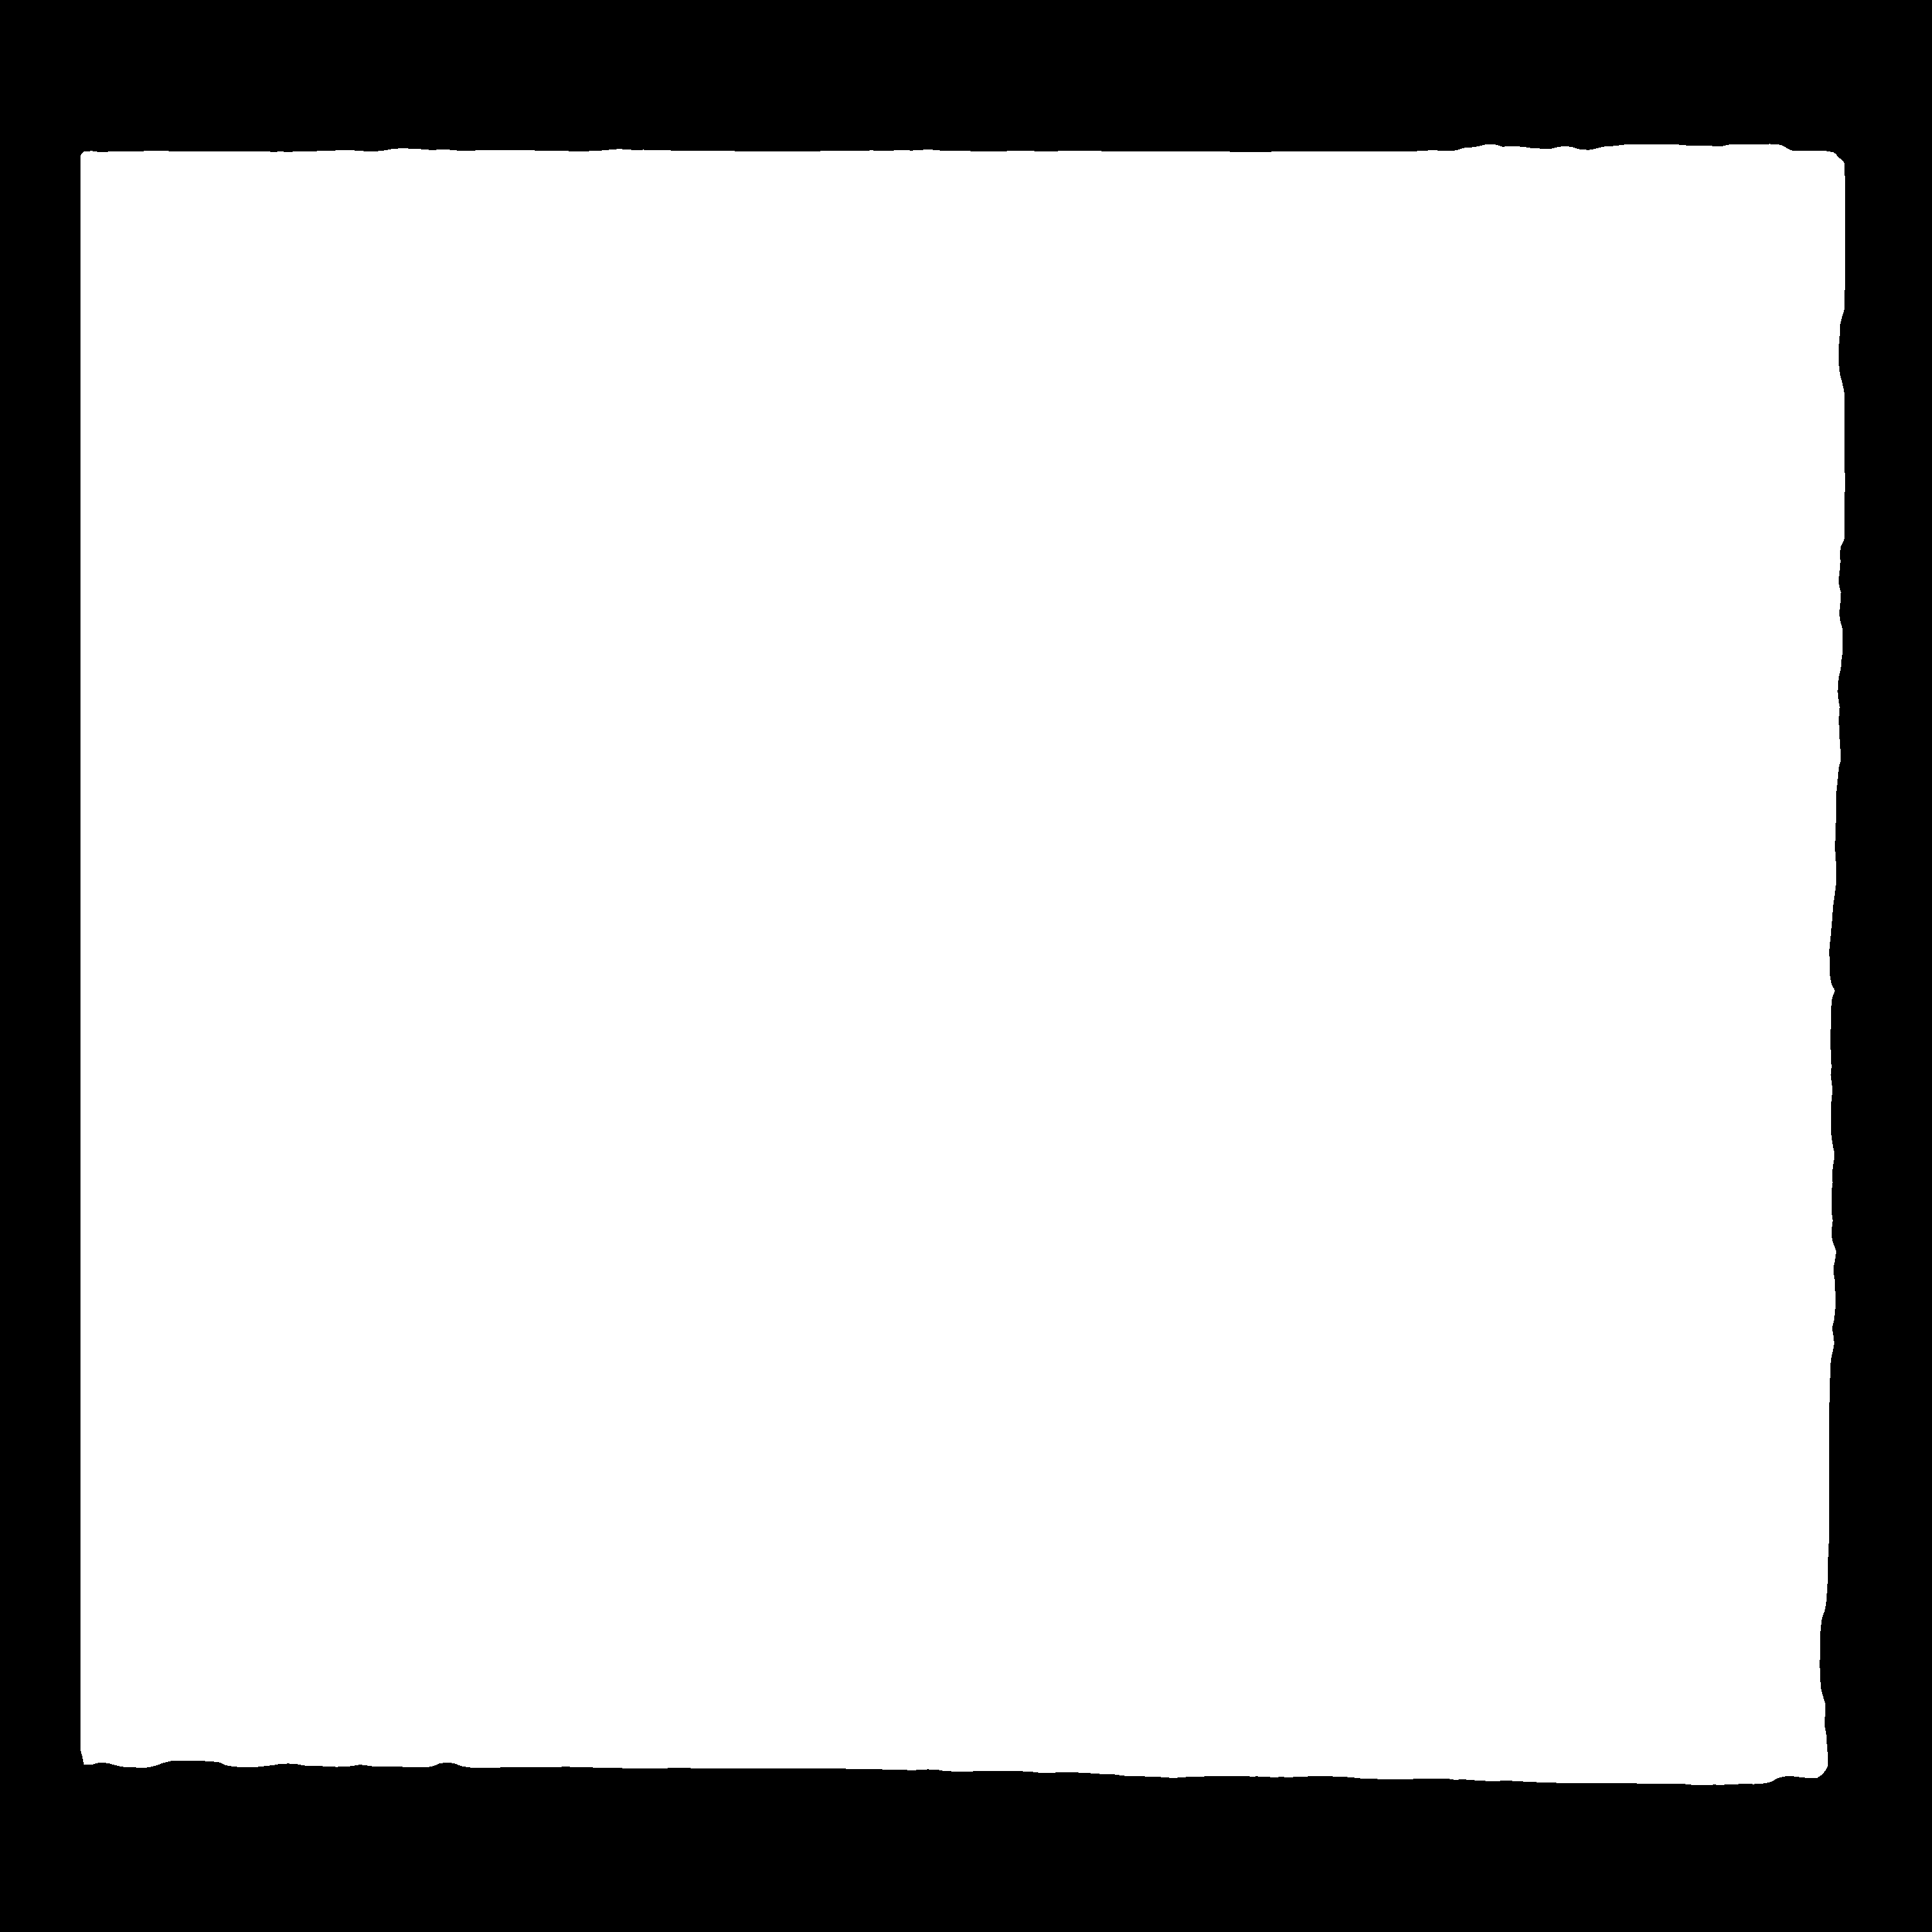

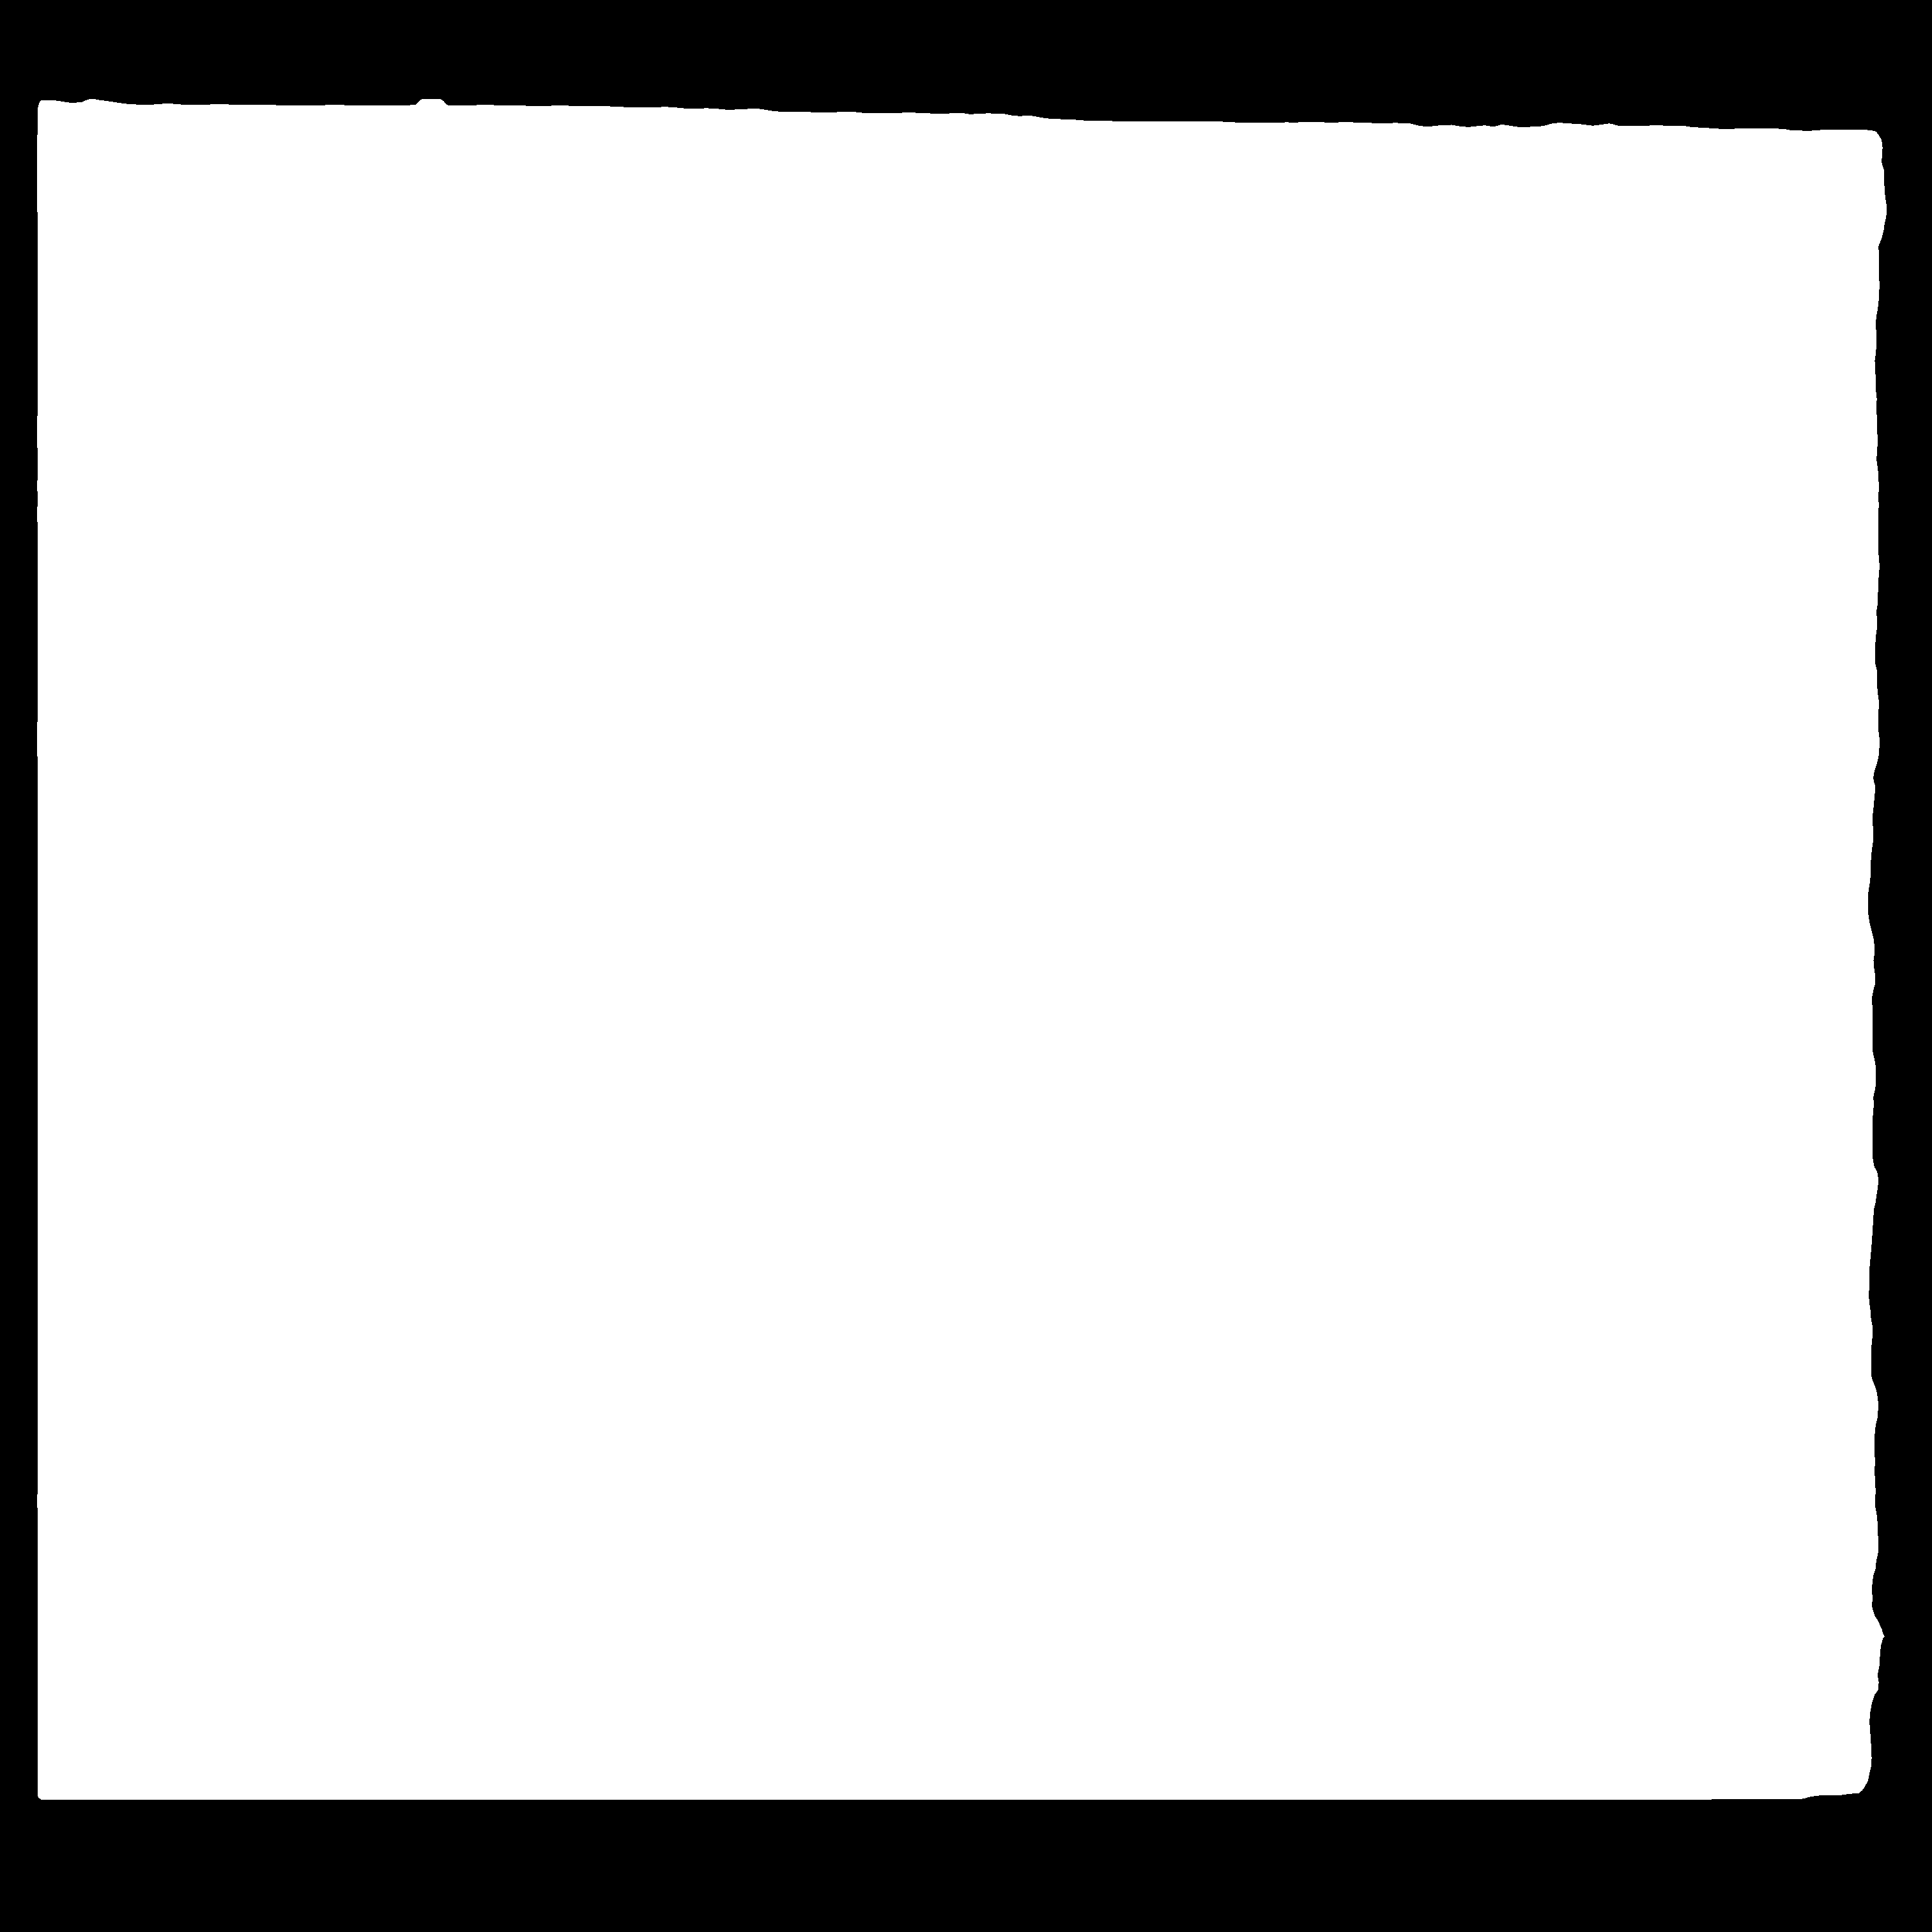

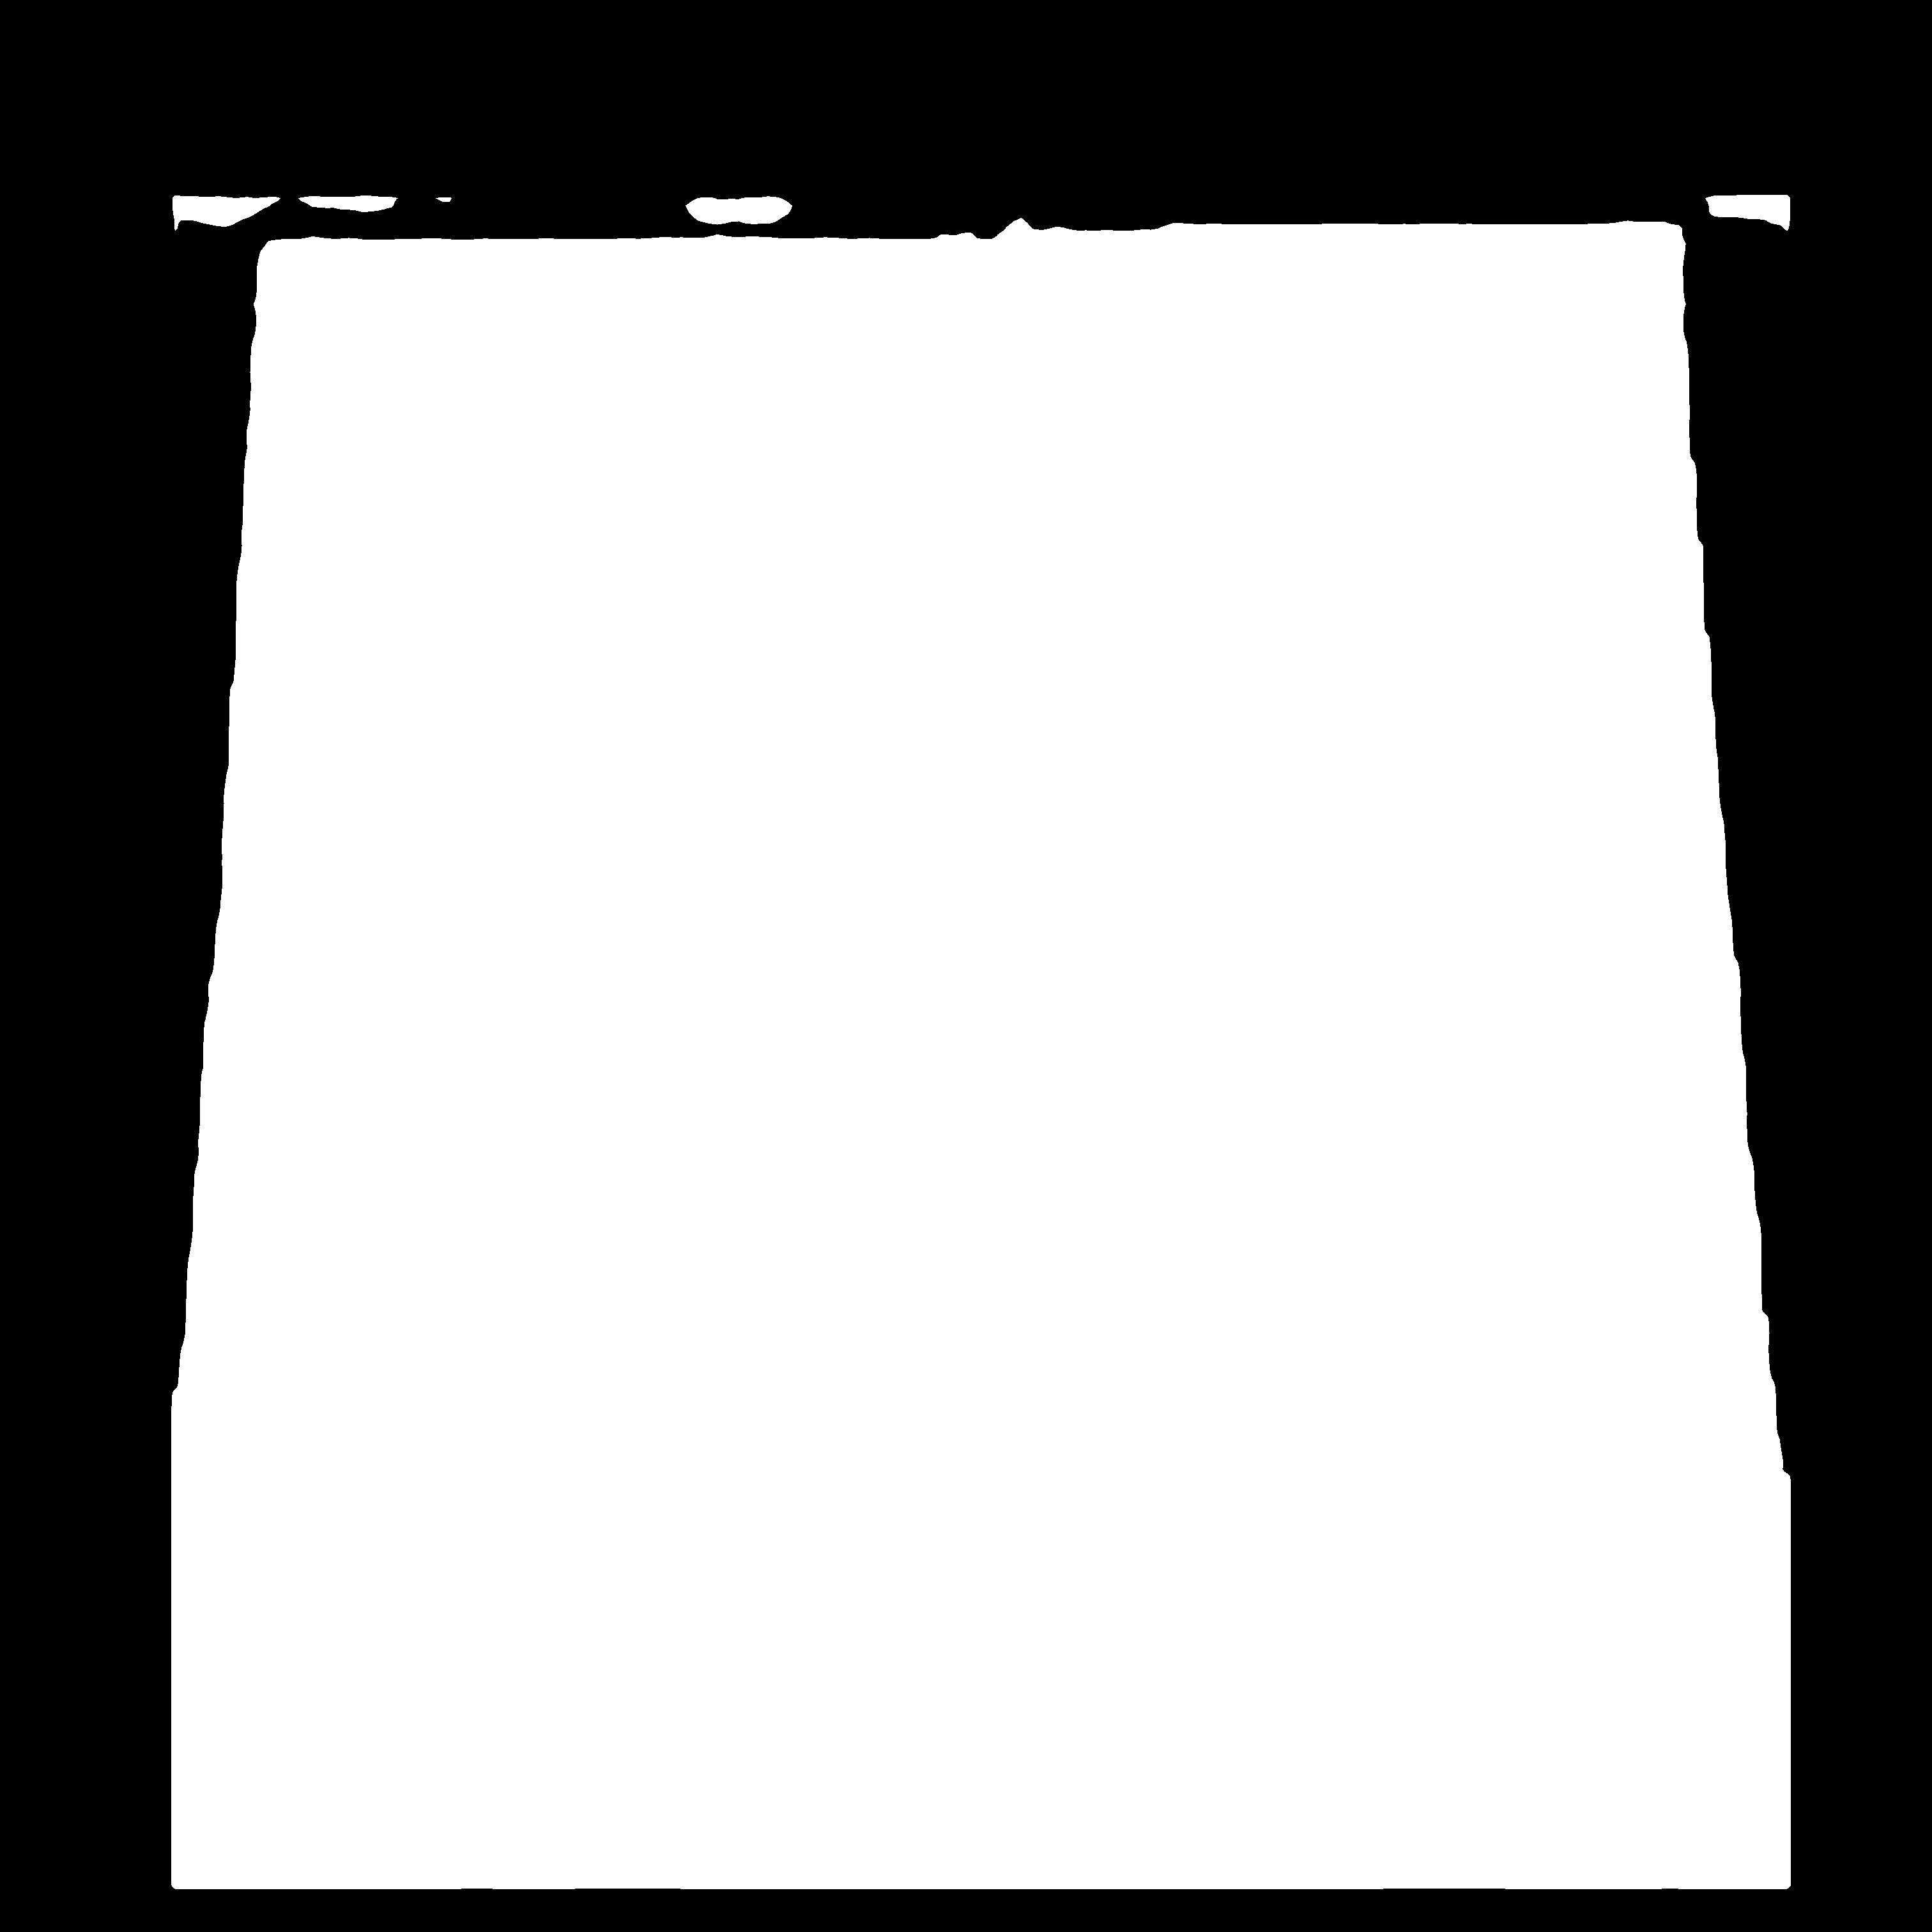

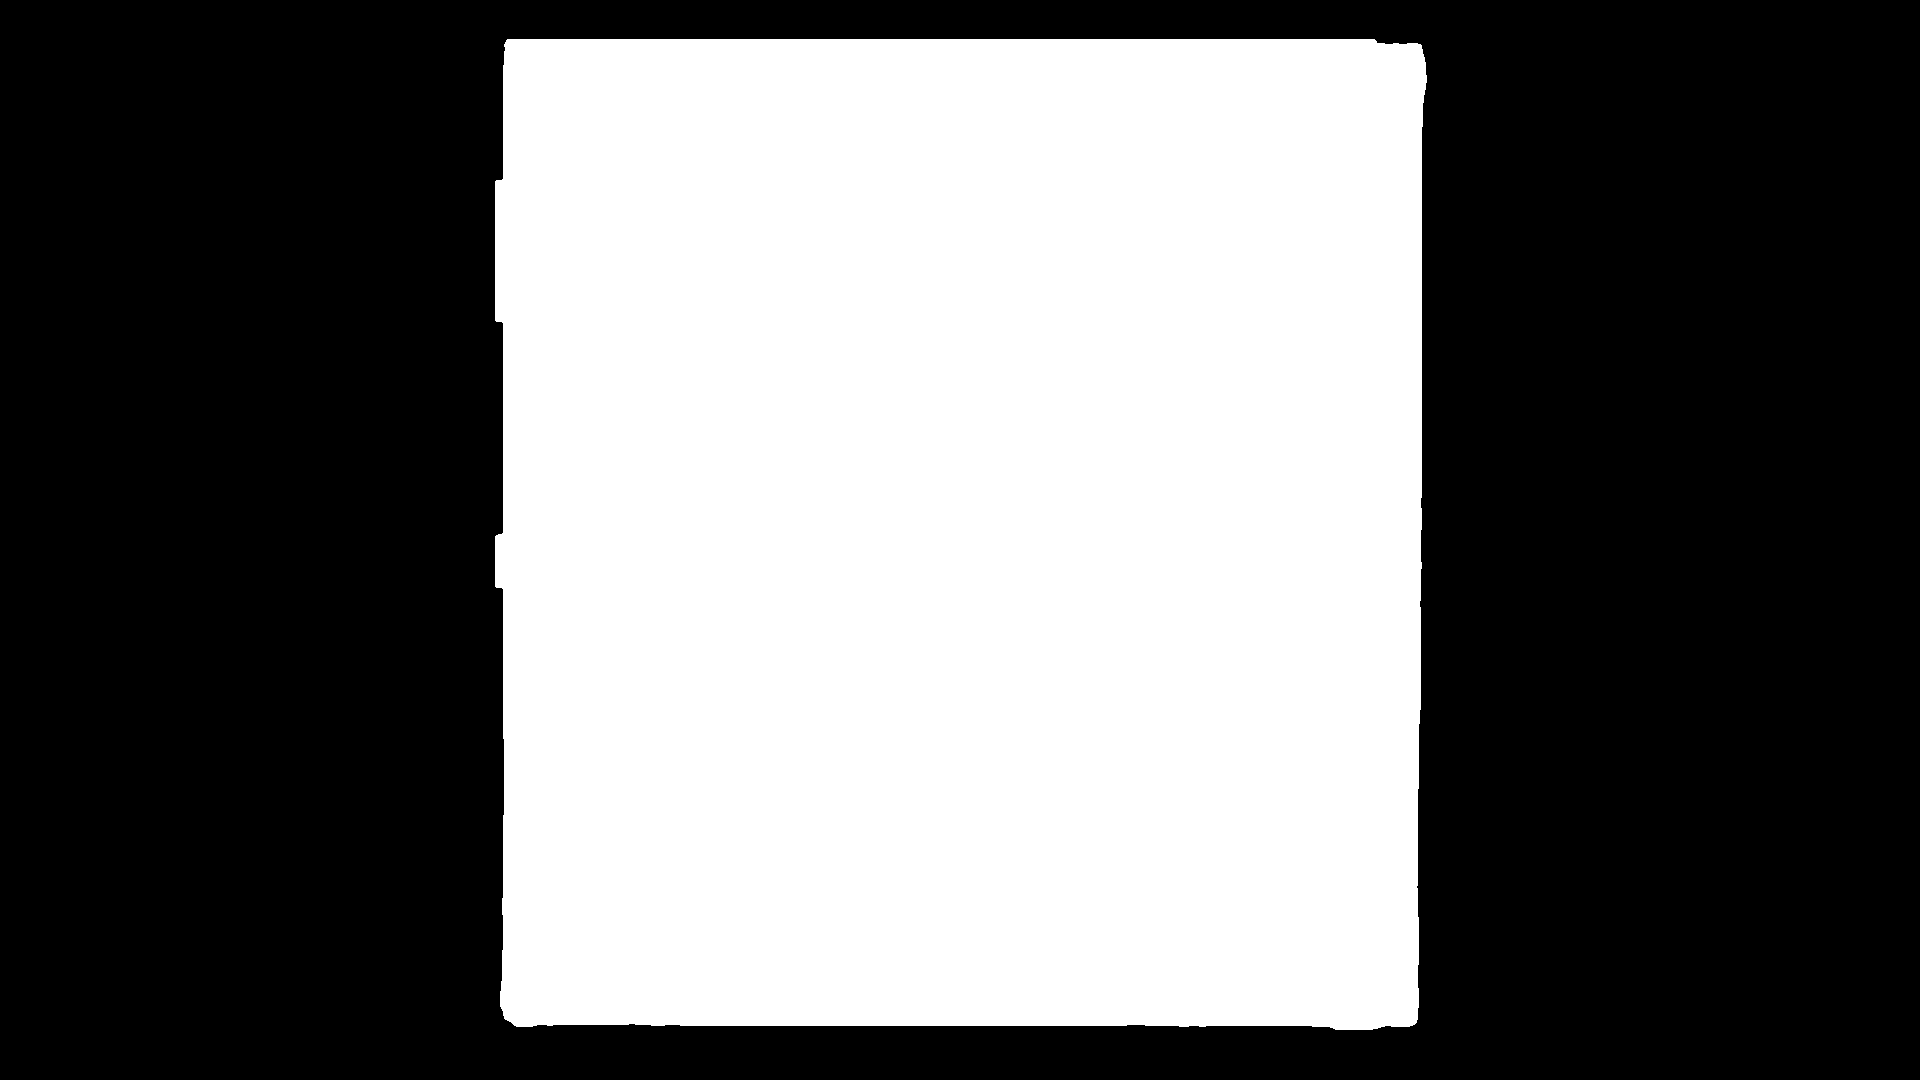

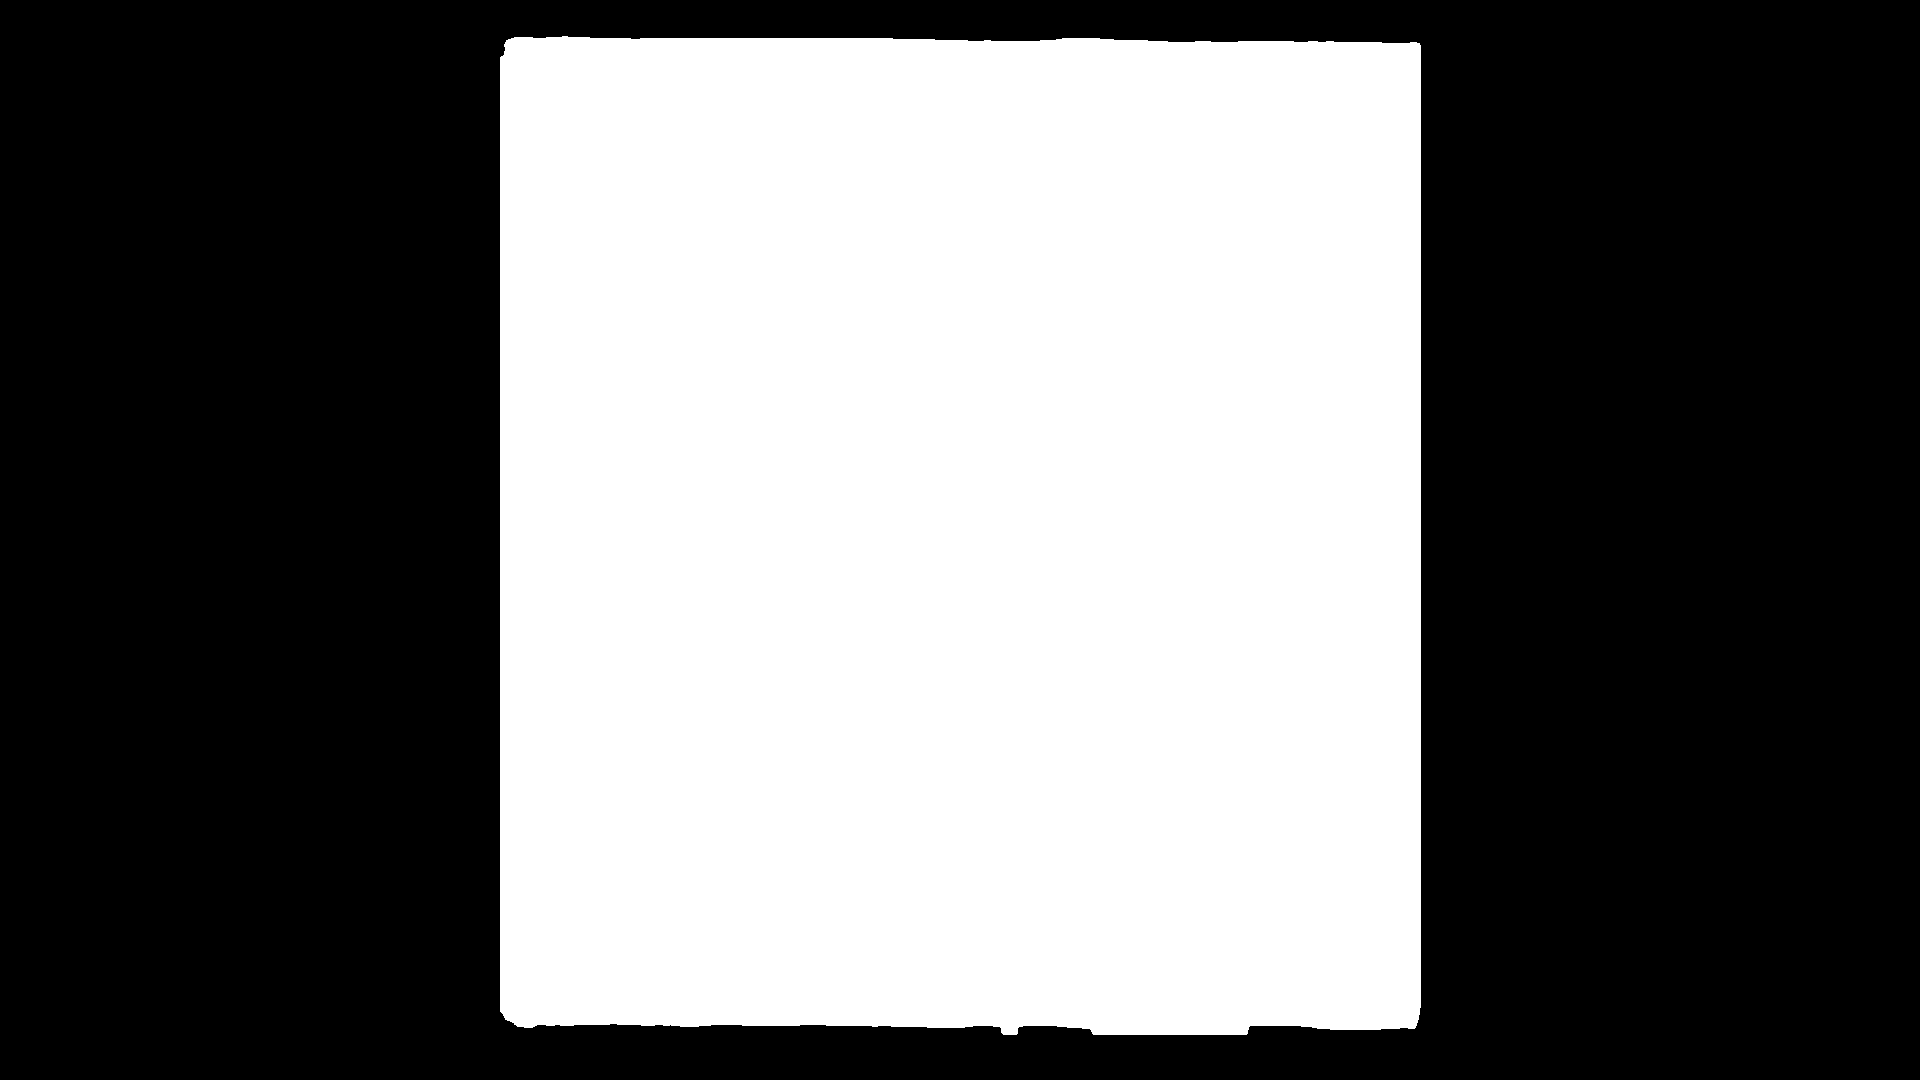

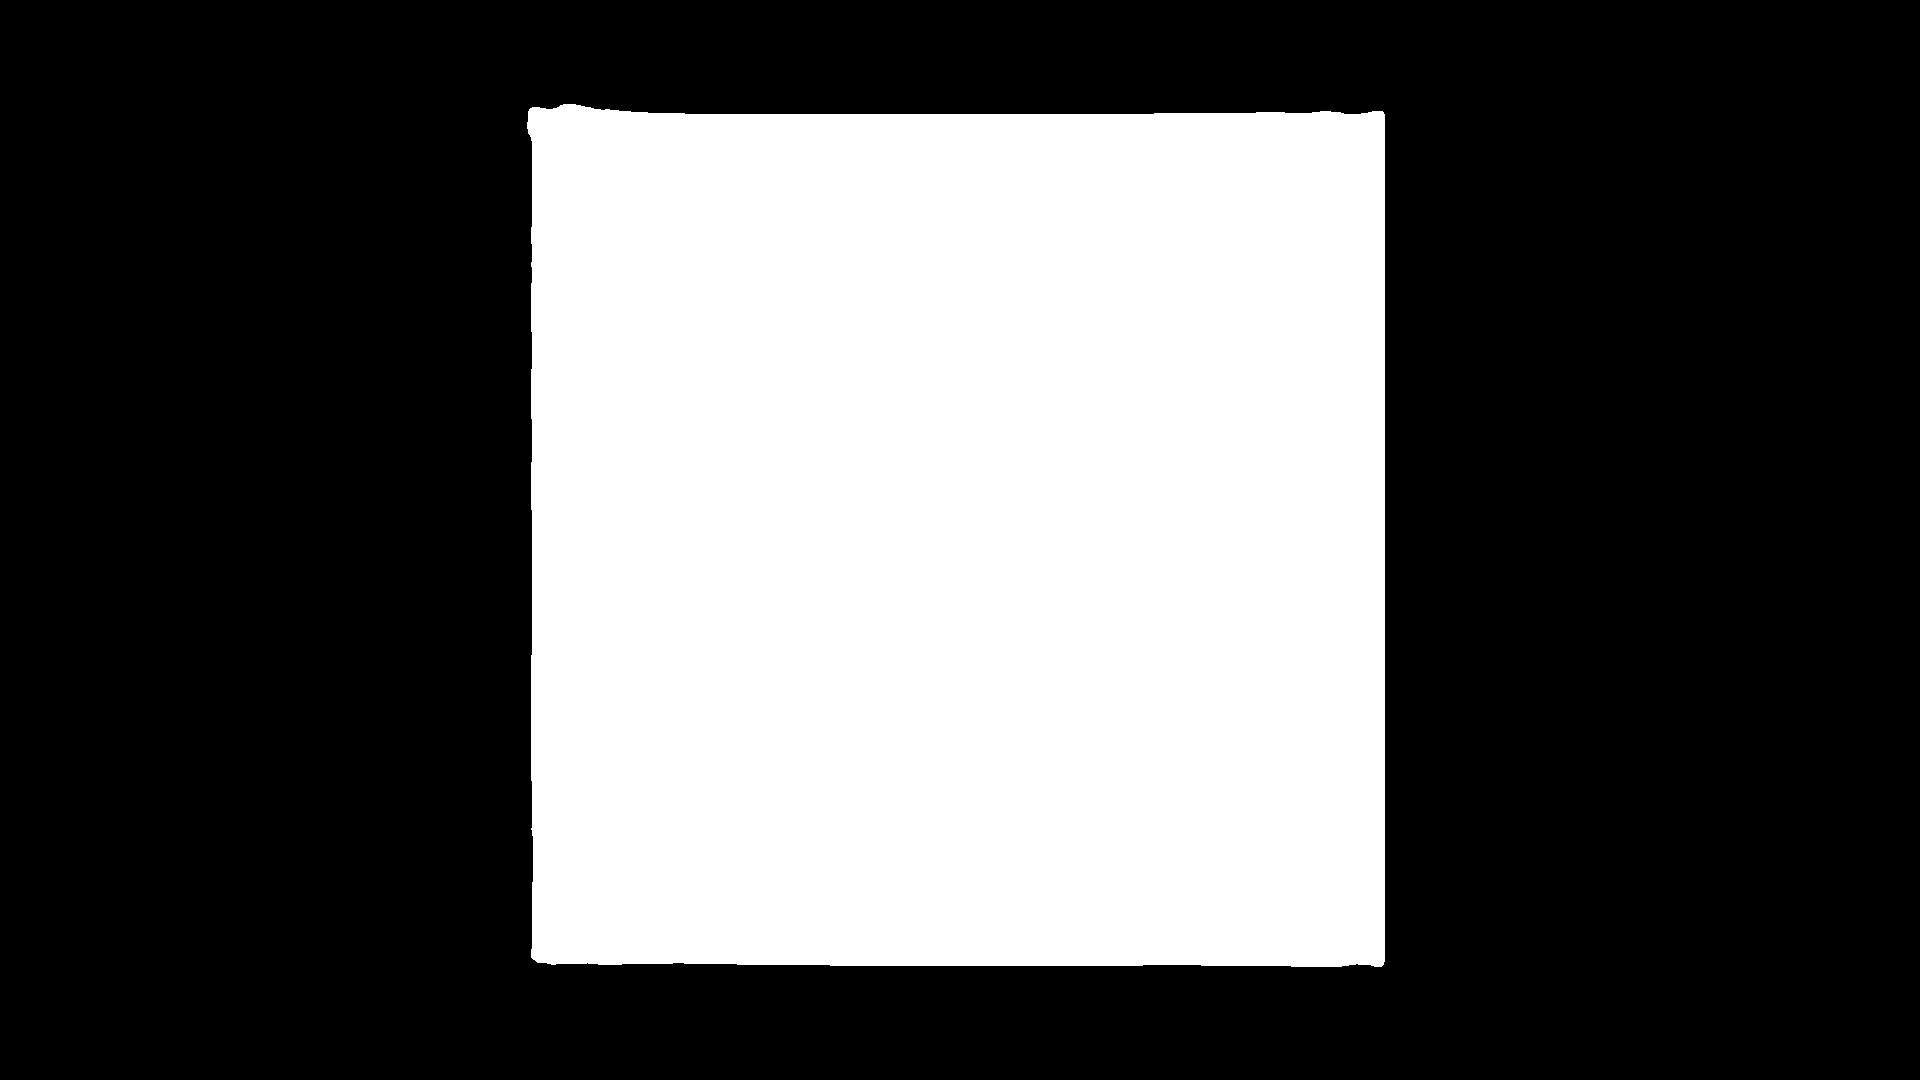

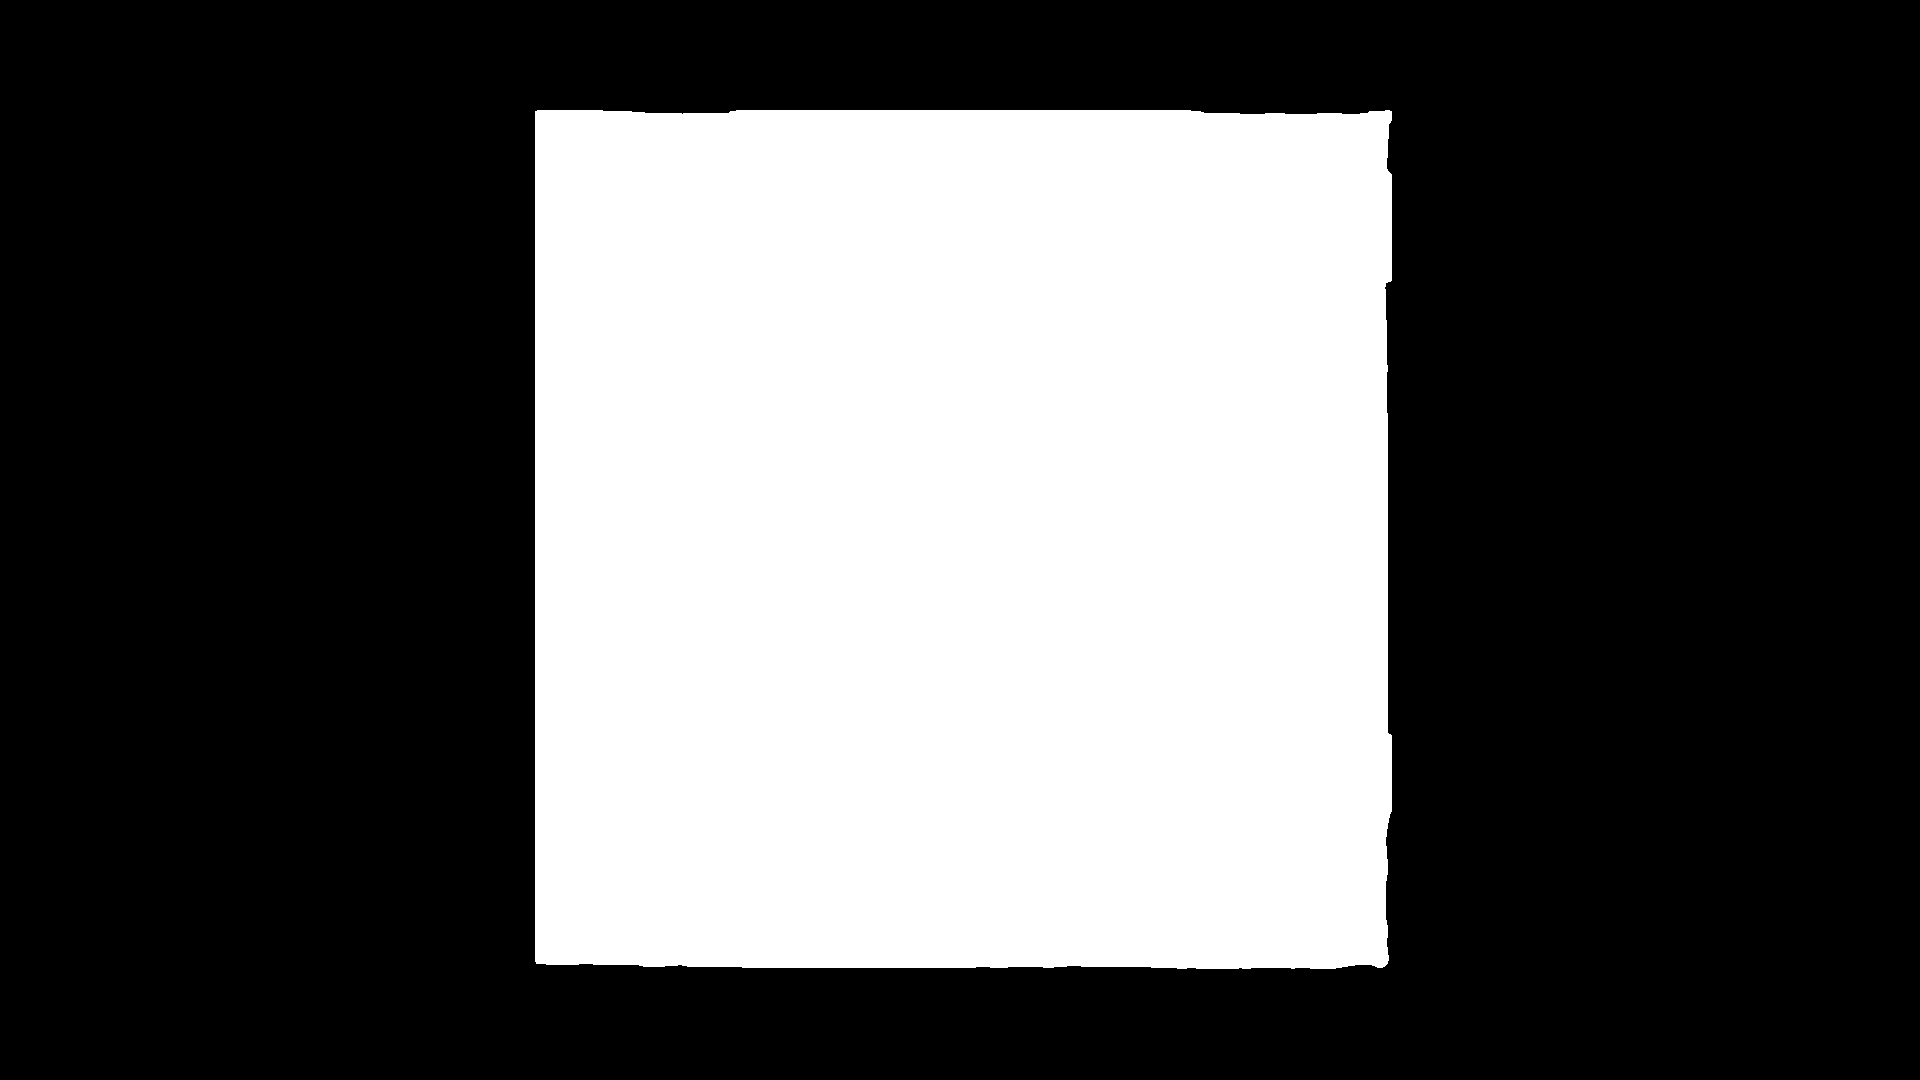

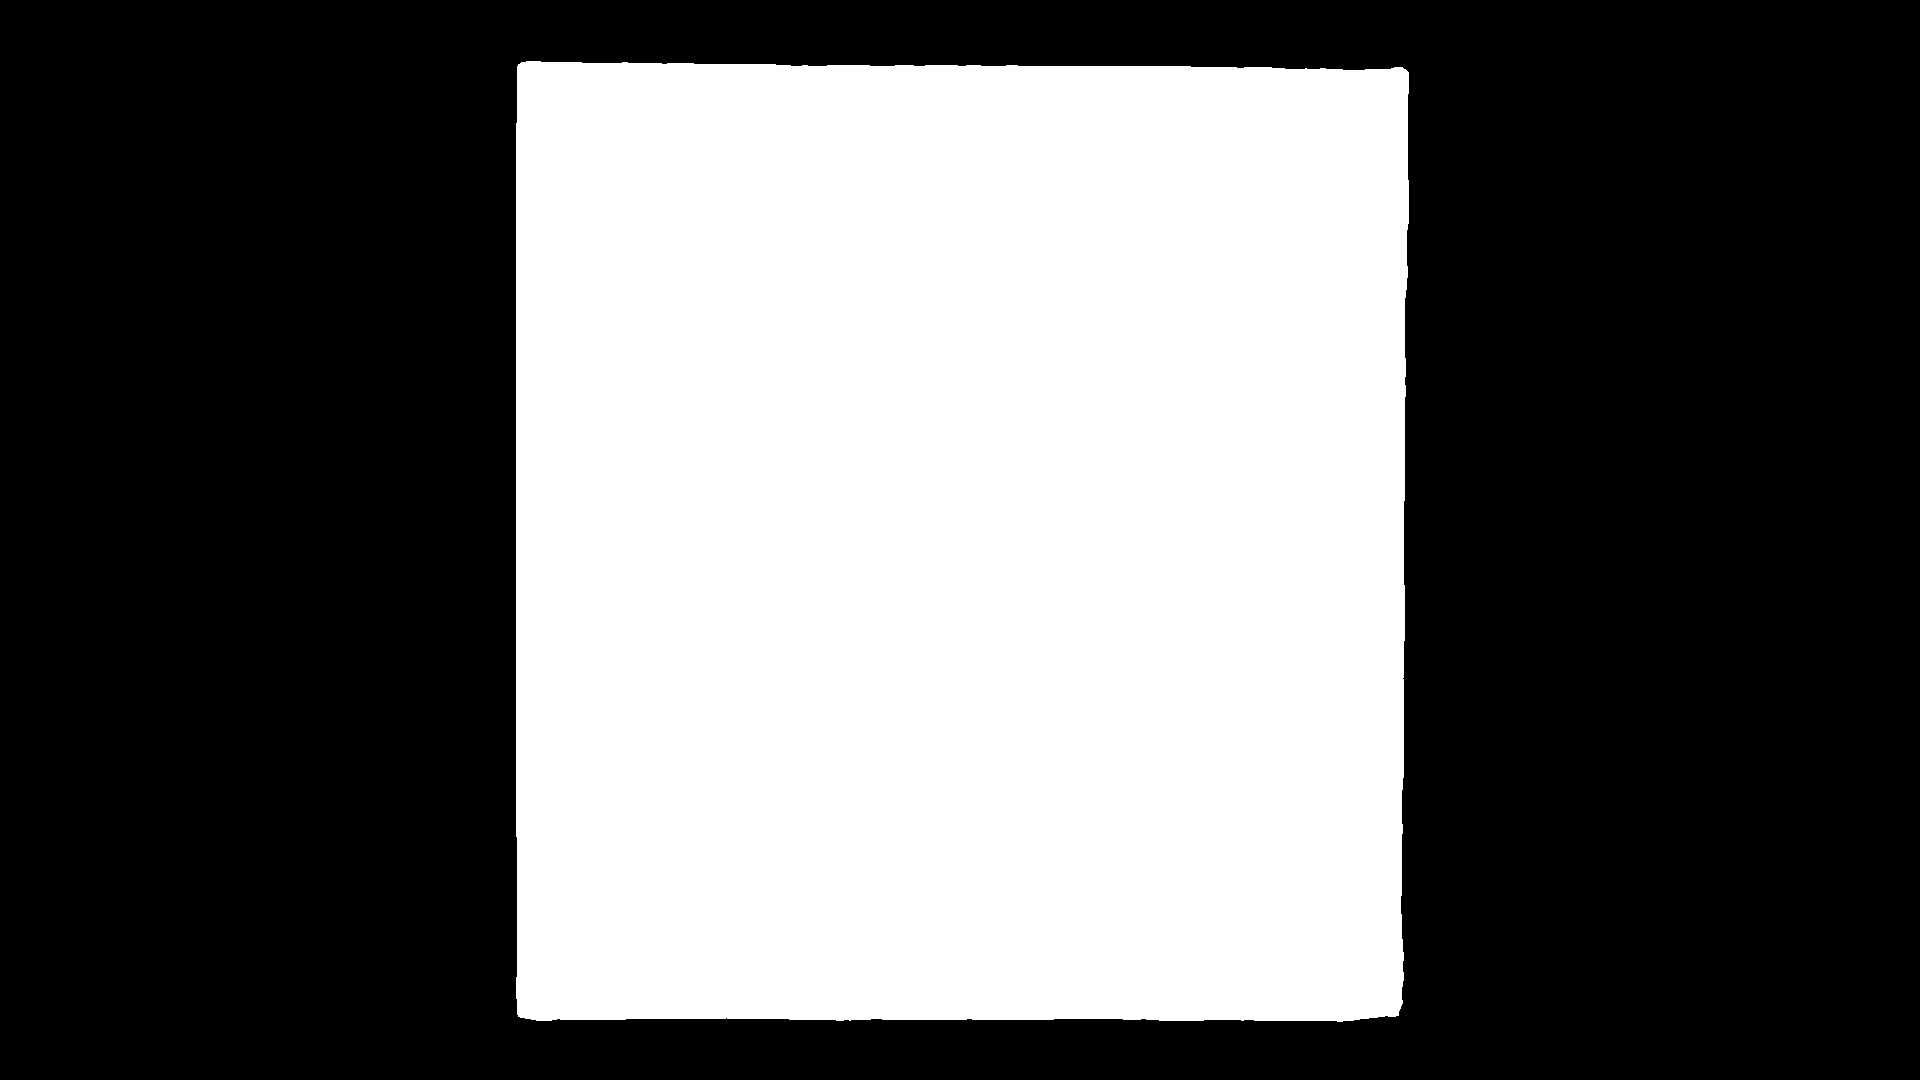

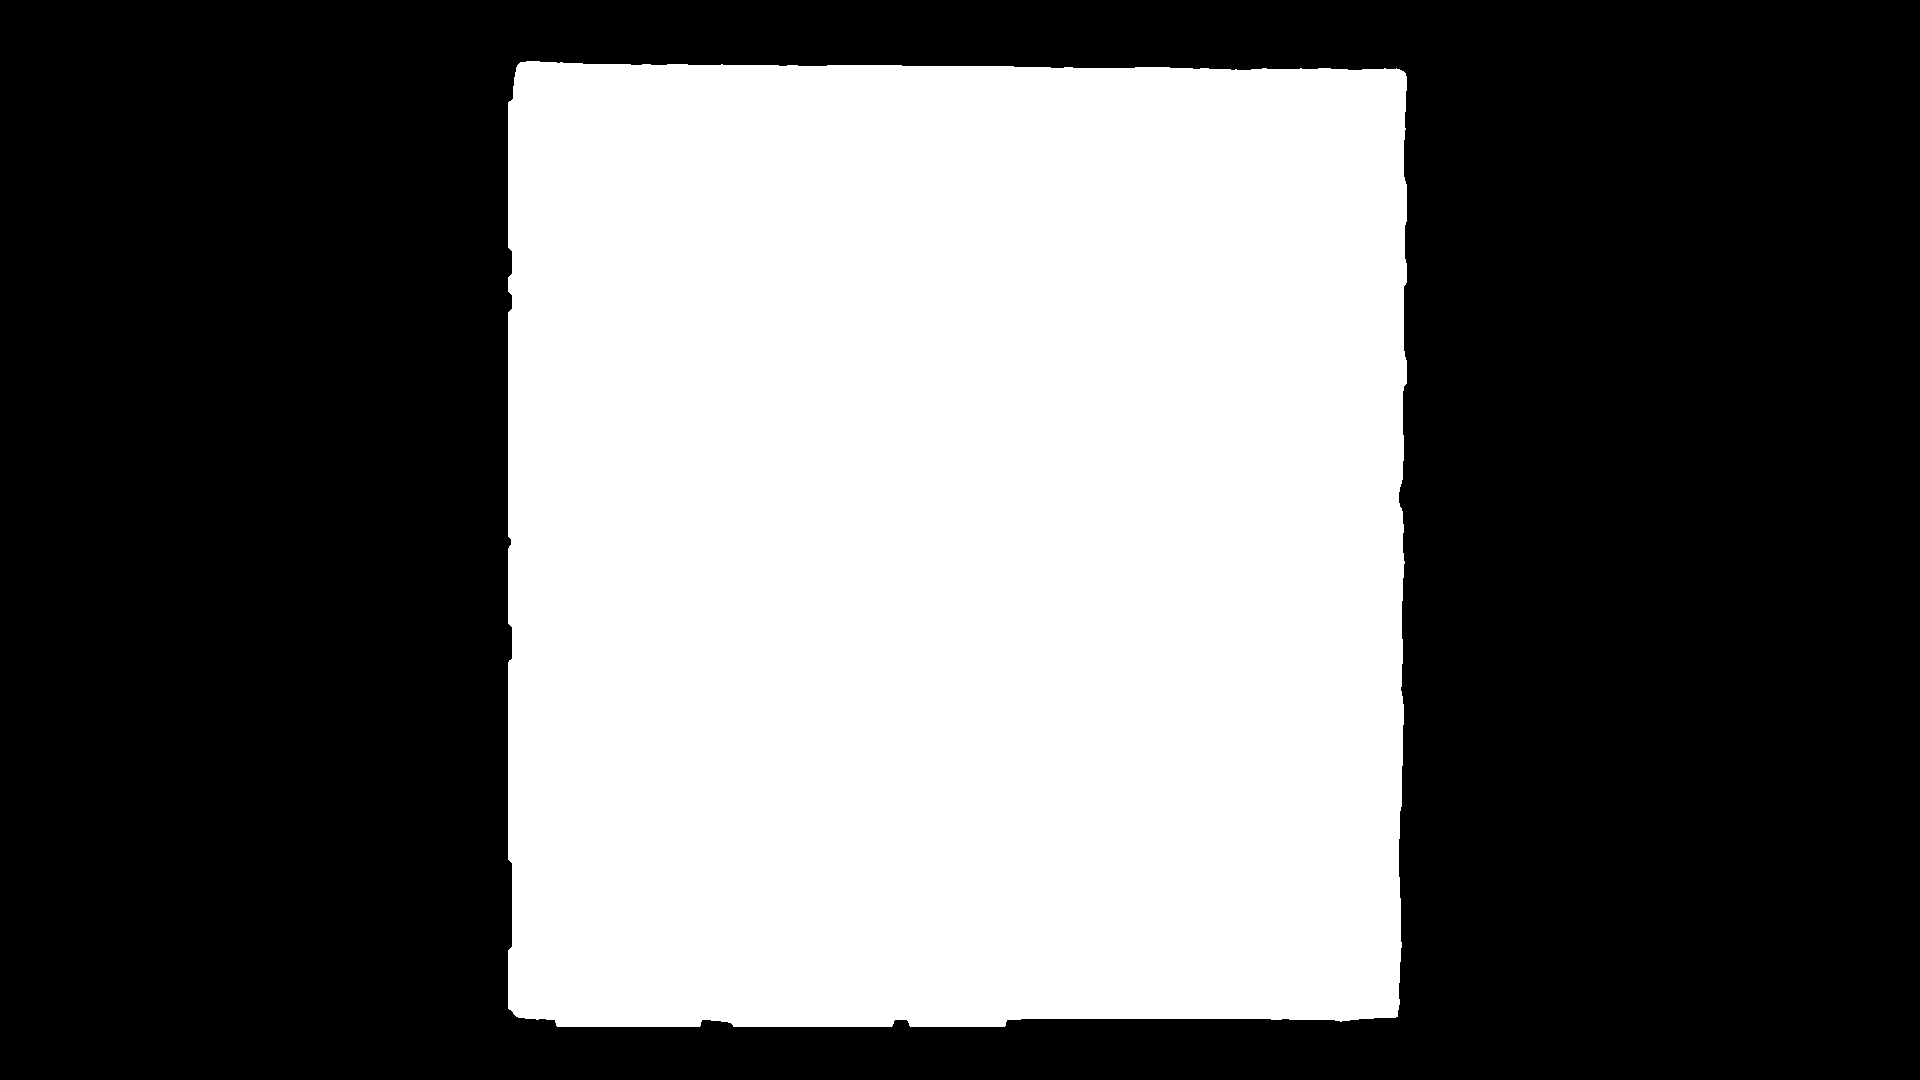

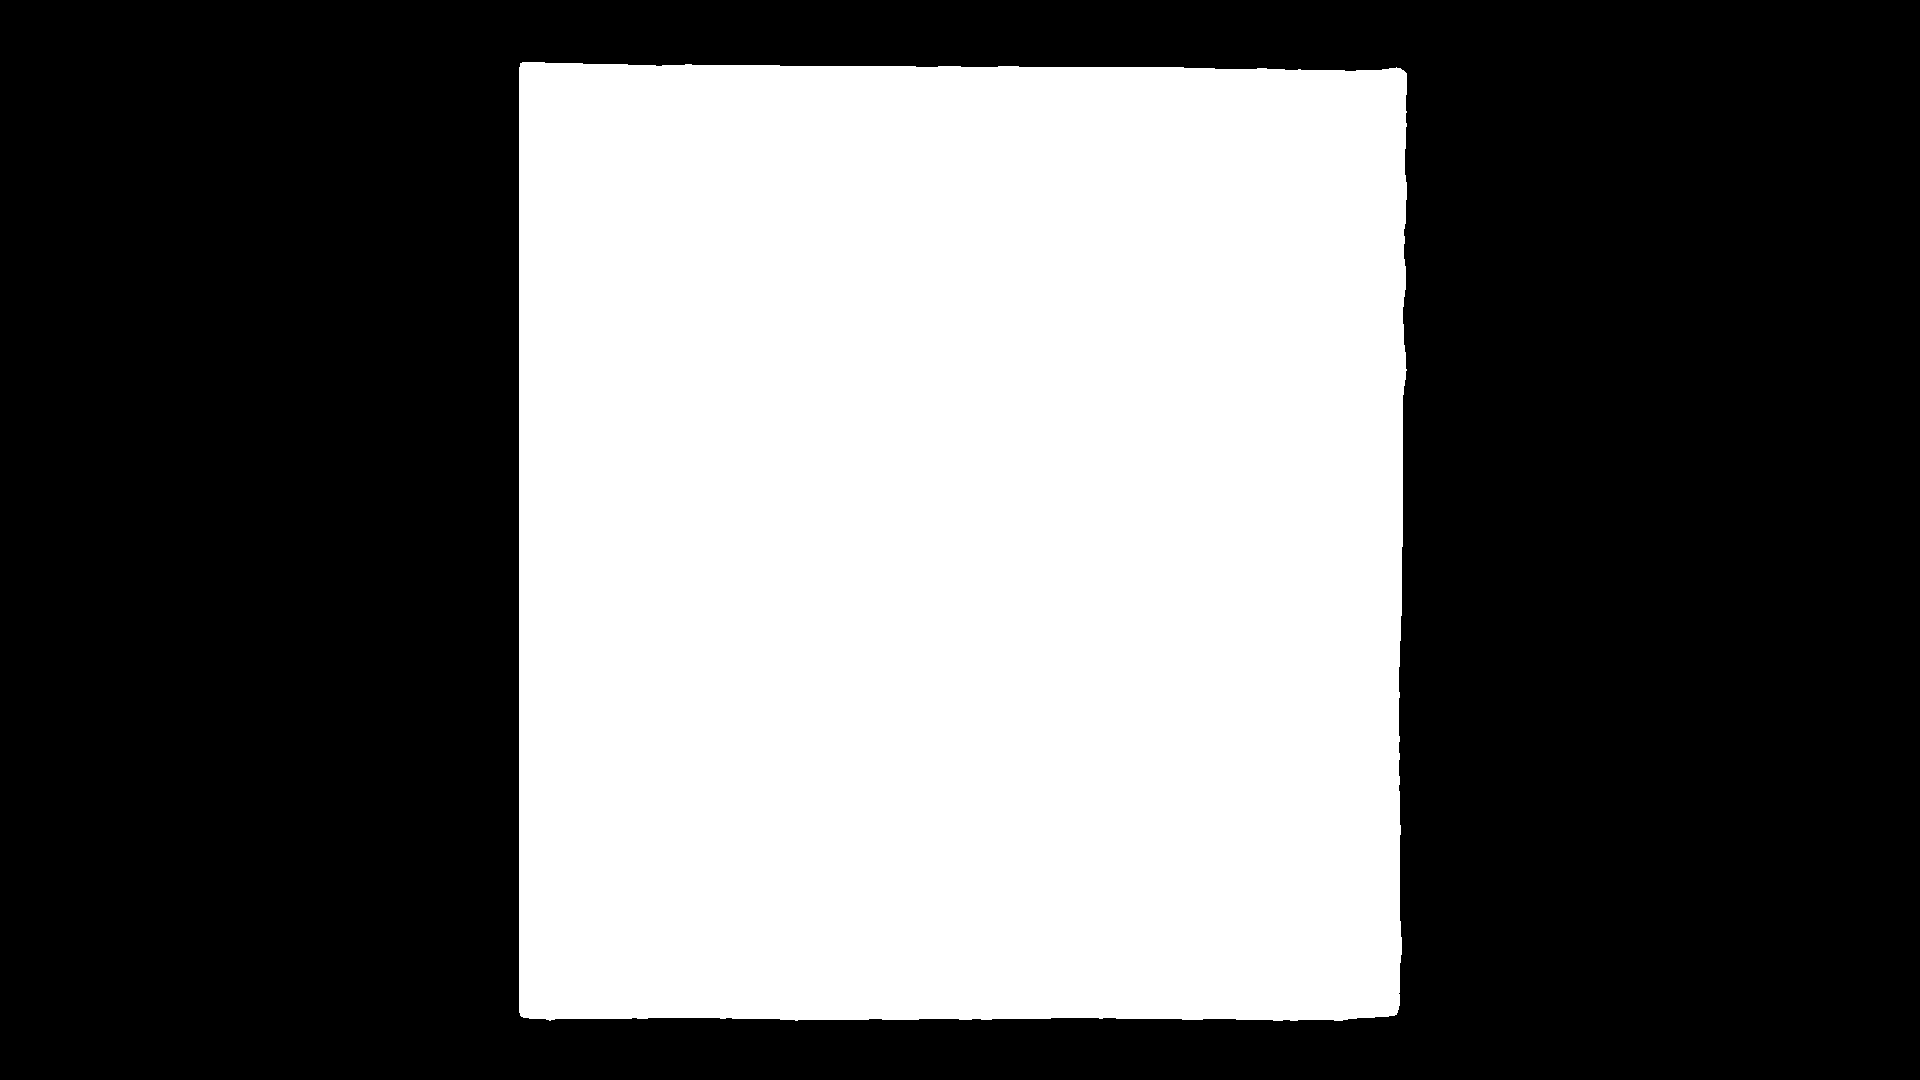

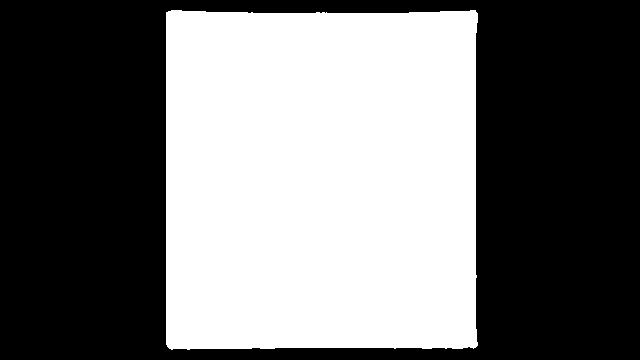

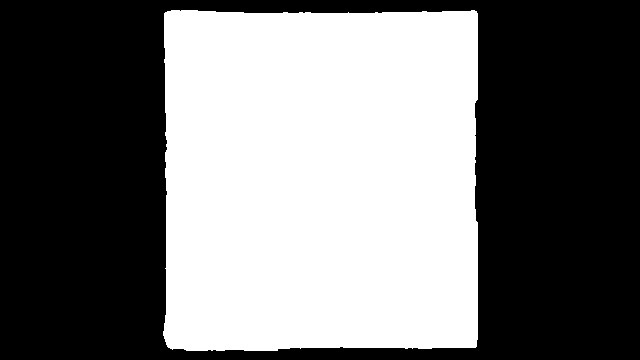

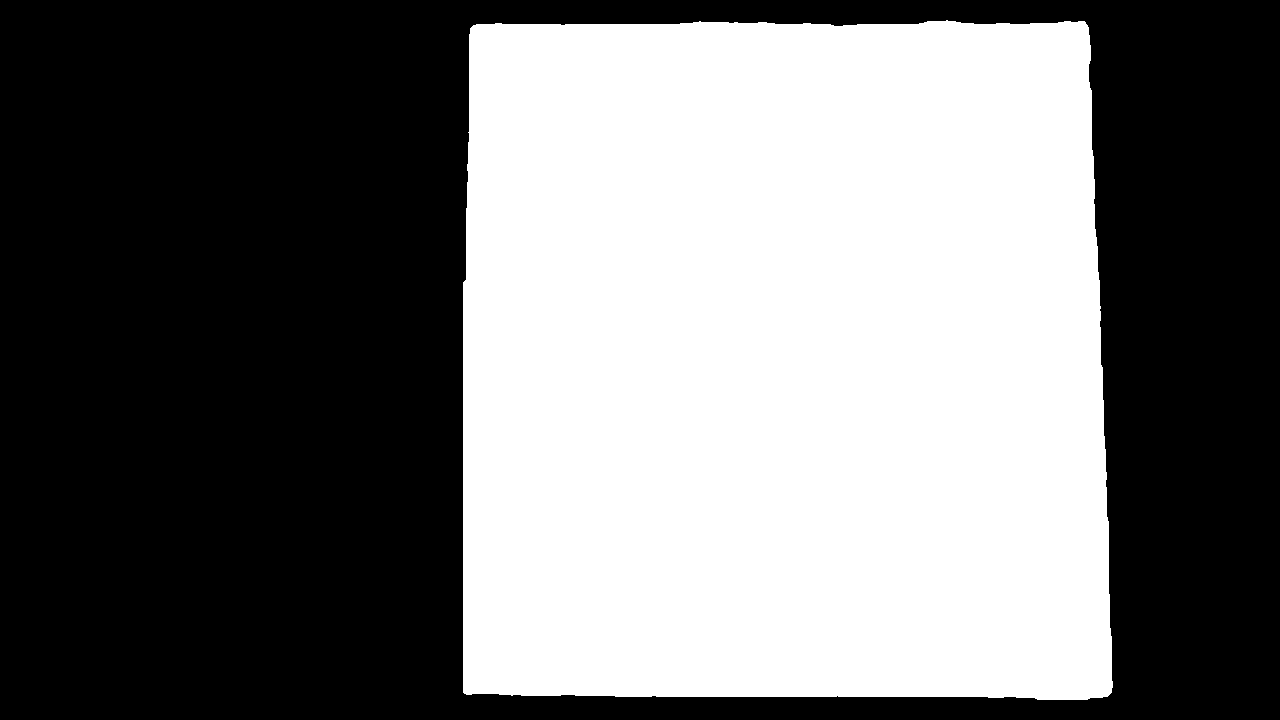

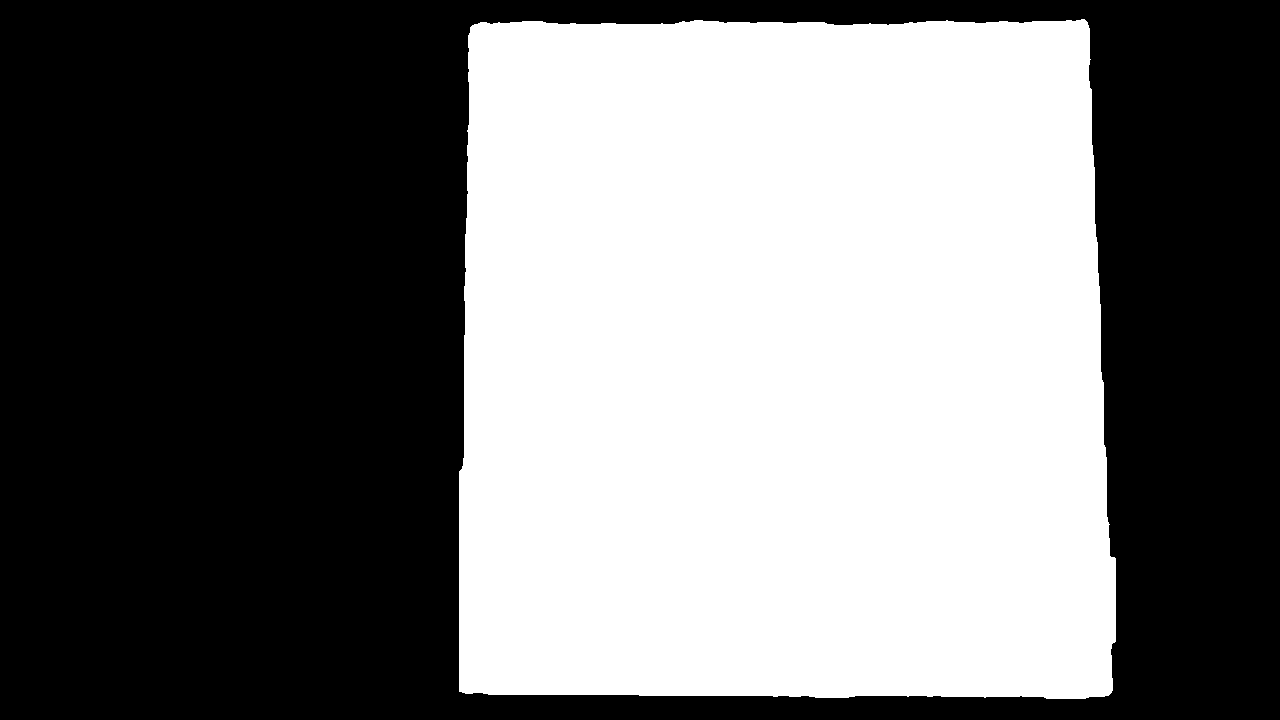

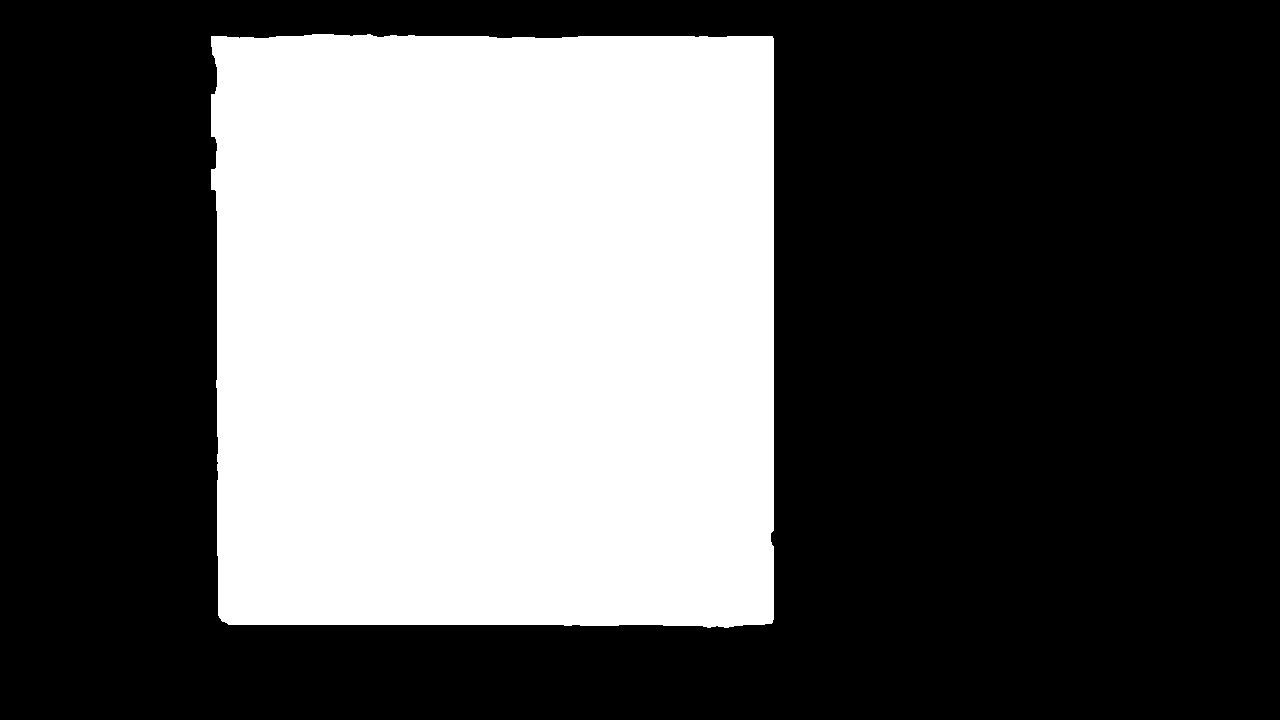

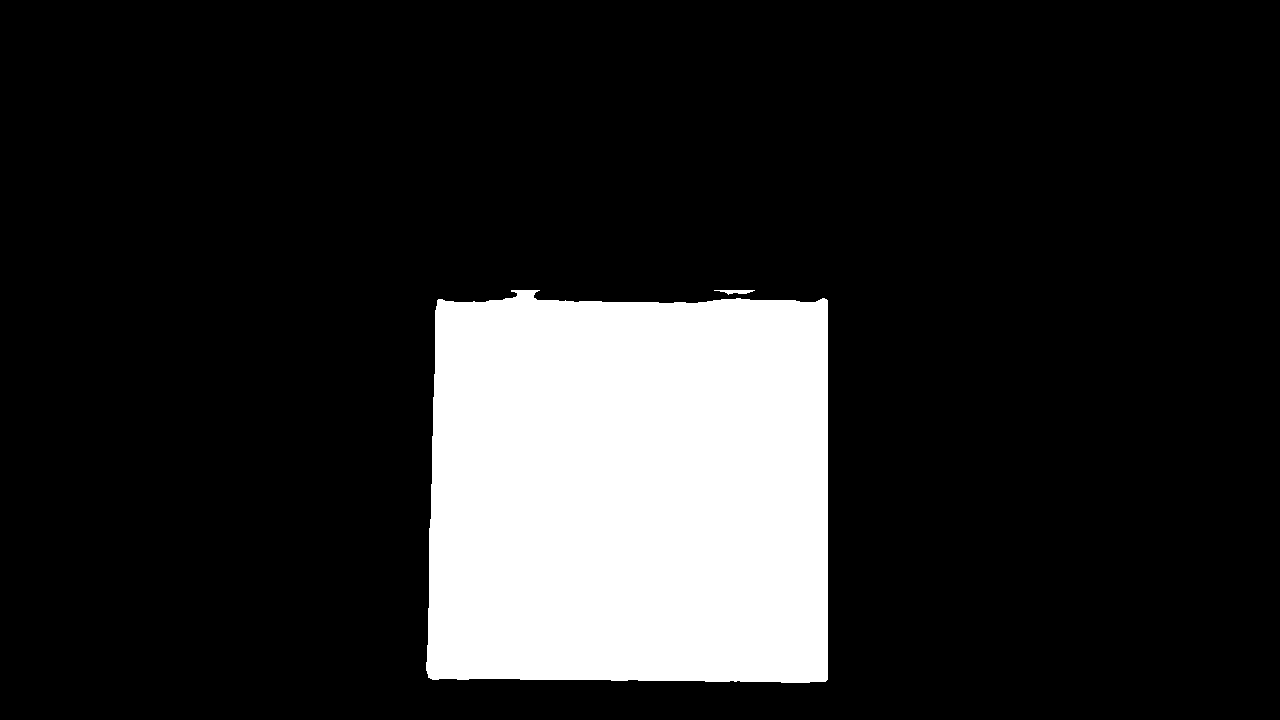

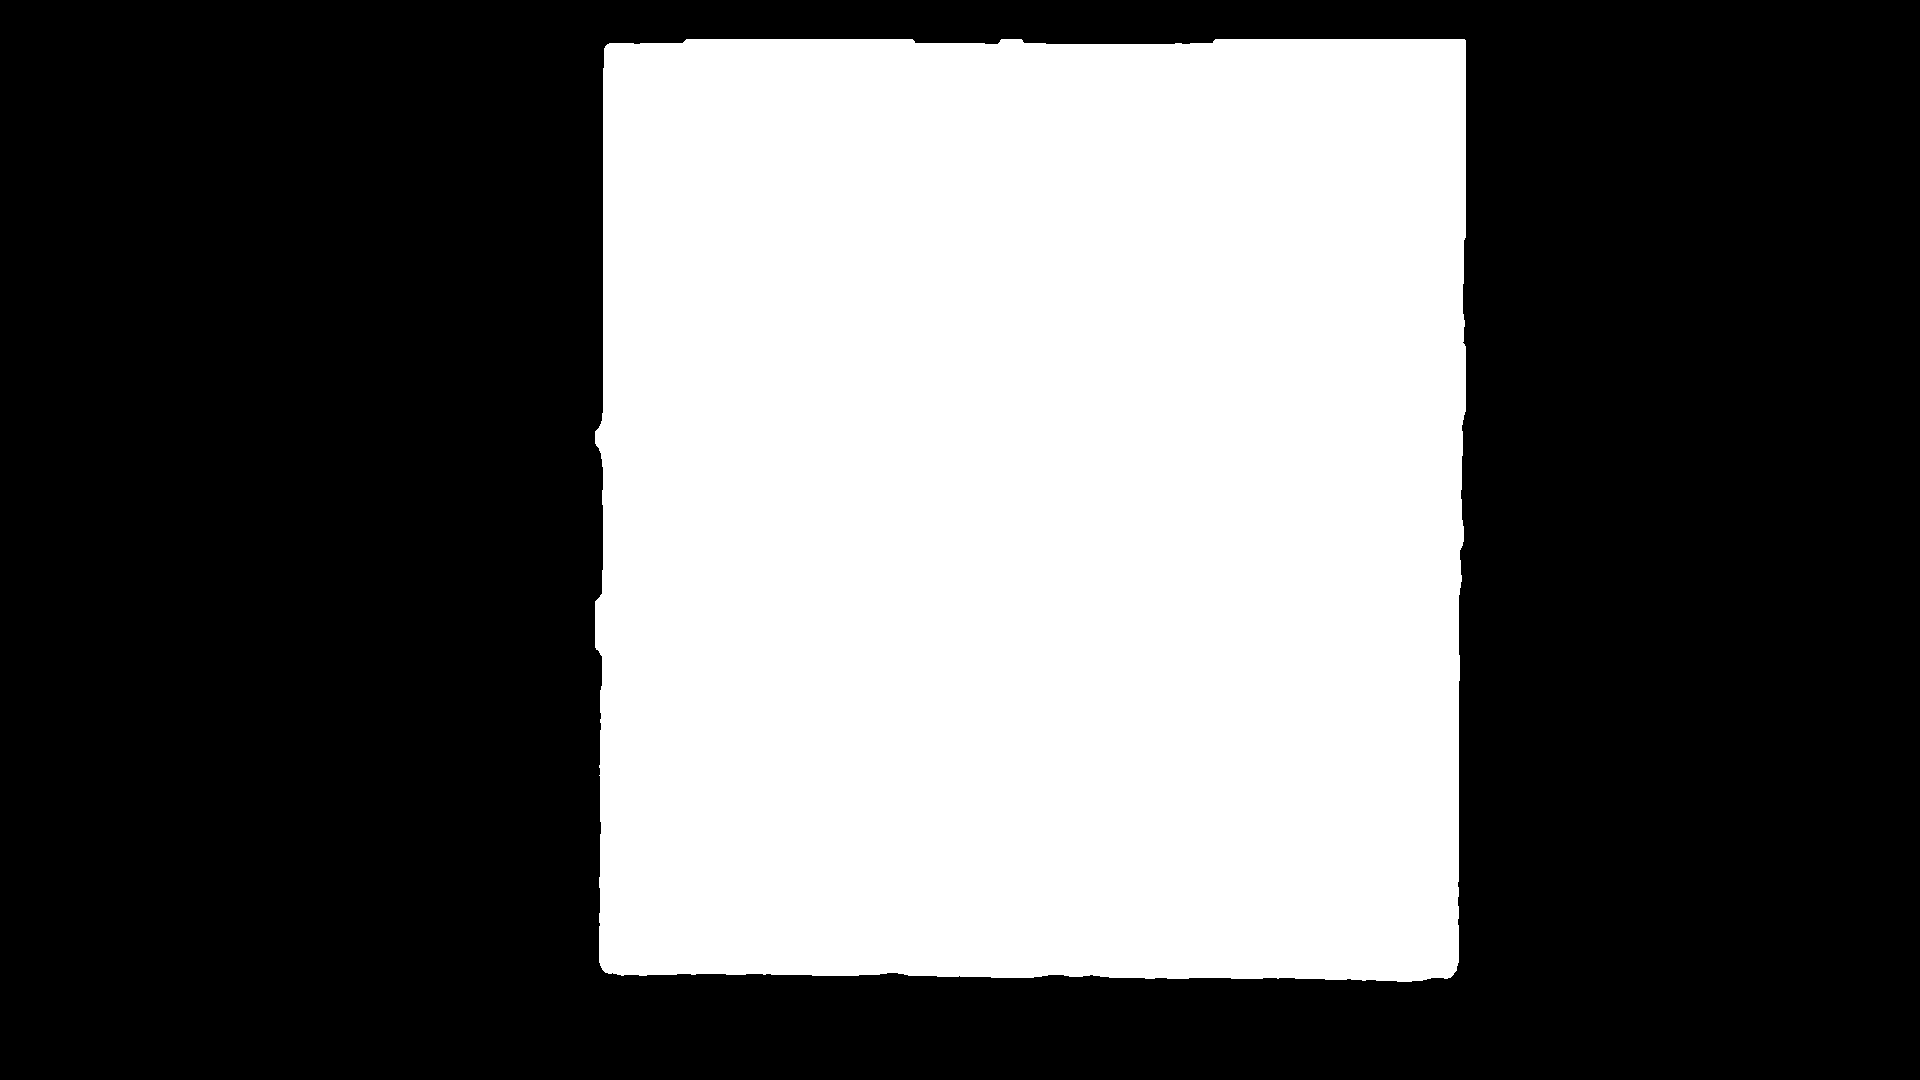

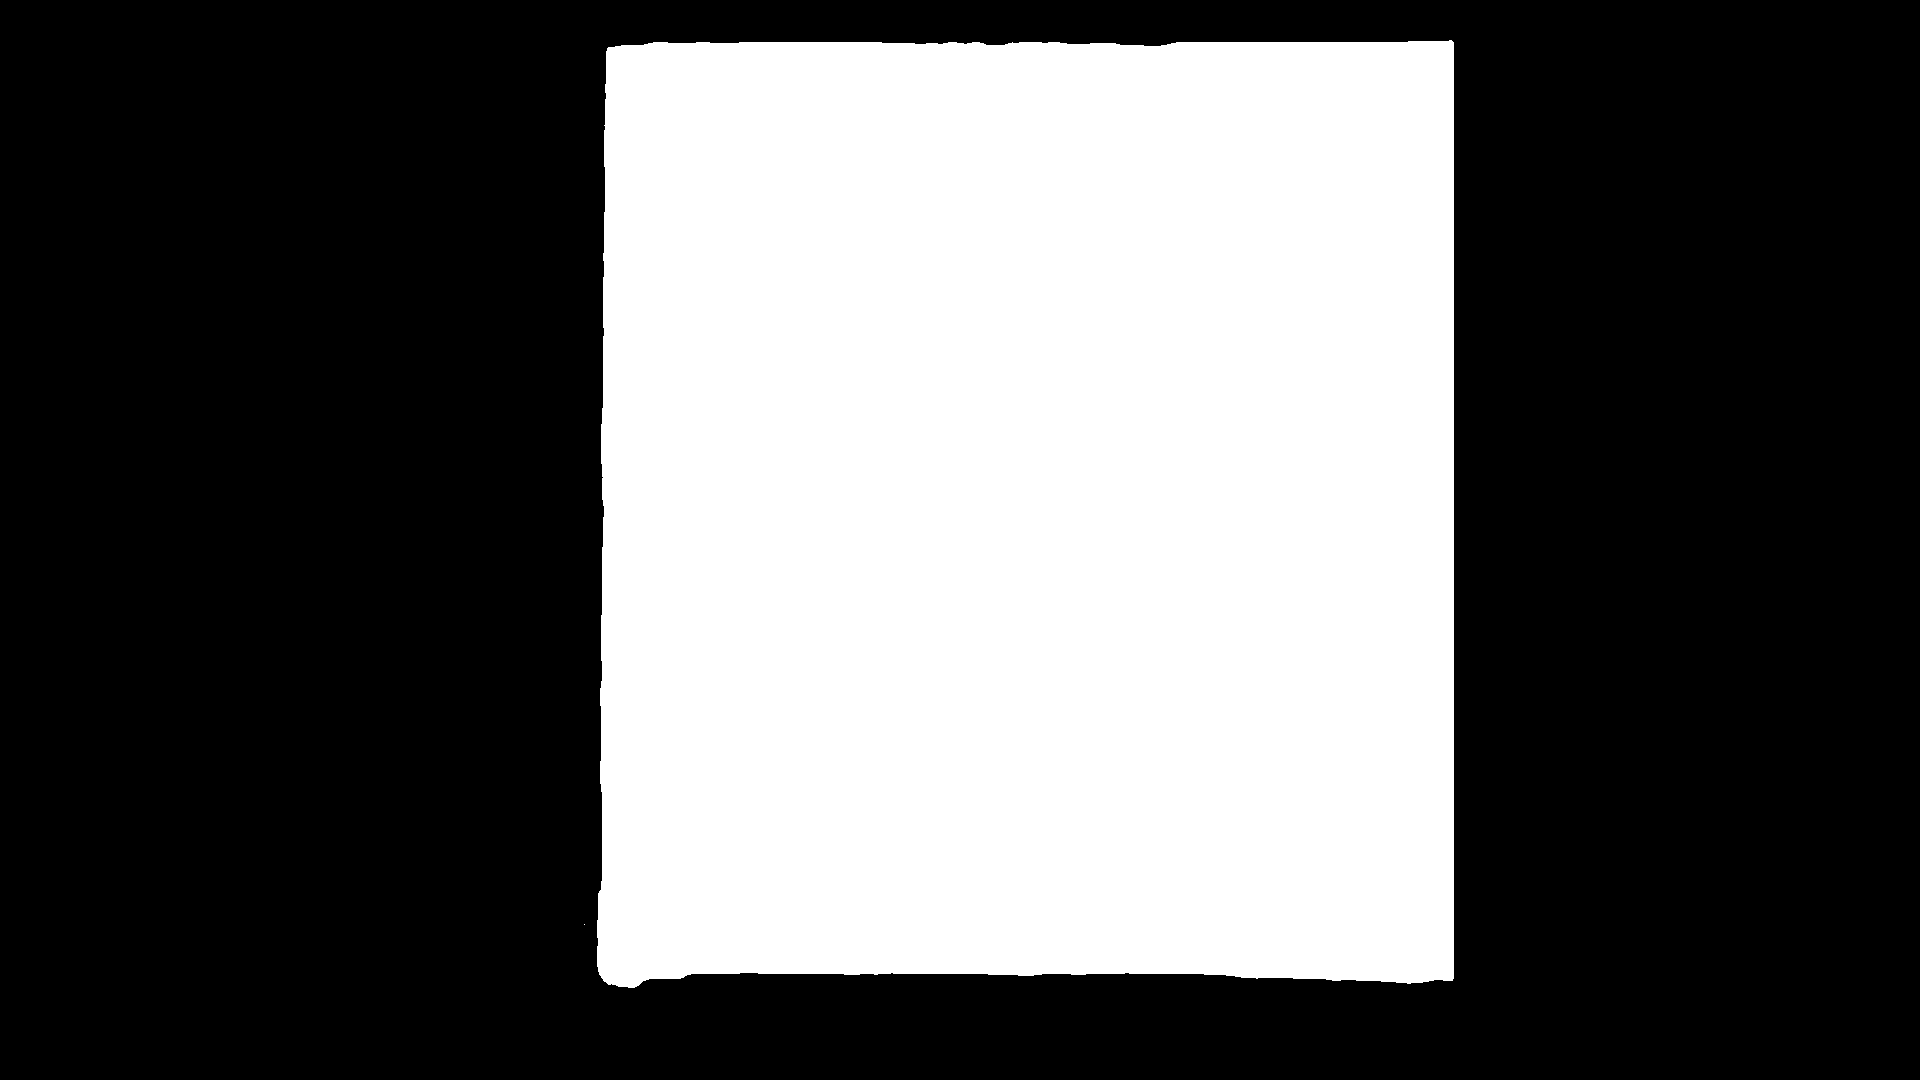

In [ ]:
from detectron2.utils.visualizer import ColorMode
import matplotlib.pyplot as plt
dataset_dicts_val = getBoarddicts(annotation_path+"/val")

for d in dataset_dicts_val :    
#for d in random.sample(dataset_dicts_val, 1):    
  
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    mask_array = outputs['instances'].pred_masks.to("cpu").numpy()
    num_instances = mask_array.shape[0]
    mask_array = np.moveaxis(mask_array, 0, -1)
    mask_array_instance = []
    output = np.zeros_like(im) #black
#print('output',output)
    for i in range(num_instances):
      mask_array_instance.append(mask_array[:, :, i:(i+1)])
      output = np.where(mask_array_instance[i] == True, 255, output)
    cv2_imshow(output)


In [ ]:
from detectron2.utils.visualizer import ColorMode
import matplotlib.pyplot as plt
dataset_dicts_val = getBoarddicts(annotation_path+"/val")

for d in dataset_dicts_val :    
#for d in random.sample(dataset_dicts_val, 1):    
  
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    mask_array = outputs['instances'].pred_masks.to("cpu").numpy()
    num_instances = mask_array.shape[0]
    mask_array = np.moveaxis(mask_array, 0, -1)
    mask_array_instance = []
    output = np.zeros_like(im) #black
#print('output',output)
    for i in range(num_instances):
      mask_array_instance.append(mask_array[:, :, i:(i+1)])
      output = np.where(mask_array_instance[i] == True, 255, output)
    #cv2_imshow( output)

    gray = cv2.cvtColor(output , cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
    contours, _ = cv2.findContours( thresh , cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour = contours[0] 
    cv2.drawContours( im, contours, -1, (0,255,0), 3)
    cv2_imshow( im)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from detectron2.utils.visualizer import ColorMode
import matplotlib.pyplot as plt
#dataset_dicts_val = getBoarddicts(annotation_path+"/val")

for d in dataset_dicts_val :    
#for d in random.sample(dataset_dicts_val, 1):    
  
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    mask_array = outputs['instances'].pred_masks.to("cpu").numpy()
    num_instances = mask_array.shape[0]
    mask_array = np.moveaxis(mask_array, 0, -1)
    mask_array_instance = []
    output = np.zeros_like(im) #black
#print('output',output)
    for i in range(num_instances):
      mask_array_instance.append(mask_array[:, :, i:(i+1)])
      output = np.where(mask_array_instance[i] == True, 255, output)
    #cv2_imshow( output)

    gray = cv2.cvtColor(output , cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
    contours, _ = cv2.findContours( thresh , cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour = contours[0] 
    #cv2.drawContours( im, contours, -1, (0,255,0), 3)
    #cv2_imshow( im)
    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.05 * perimeter, True)
    # drawing points
    for point in approx:
      x, y = point[0]
      cv2.circle(im, (x, y), 3, (0, 255, 0), -1)
    cv2_imshow( im)
    # drawing skewed rectangle
    #cv2.drawContours(im, [approx], -1, (0, 255, 0))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from detectron2.utils.visualizer import ColorMode
import matplotlib.pyplot as plt
#dataset_dicts_val = getBoarddicts(annotation_path+"/val")

for d in dataset_dicts_val :    
#for d in random.sample(dataset_dicts_val, 1):    
  
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    mask_array = outputs['instances'].pred_masks.to("cpu").numpy()
    num_instances = mask_array.shape[0]
    mask_array = np.moveaxis(mask_array, 0, -1)
    mask_array_instance = []
    output = np.zeros_like(im) #black
#print('output',output)
    for i in range(num_instances):
      mask_array_instance.append(mask_array[:, :, i:(i+1)])
      output = np.where(mask_array_instance[i] == True, 255, output)
    #cv2_imshow( output)

    gray = cv2.cvtColor(output , cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
    contours, _ = cv2.findContours( thresh , cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour = contours[0] 
    #cv2.drawContours( im, contours, -1, (0,255,0), 3)
    #cv2_imshow( im)
    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.05 * perimeter, True)
    # drawing points
    for point in approx:
      x, y = point[0]
      cv2.circle(im, (x, y), 3, (0, 255, 0), -1)
   # cv2_imshow( im)
    # drawing skewed rectangle
    cv2.drawContours(im, [approx], -1, (0, 255, 0))

Output hidden; open in https://colab.research.google.com to view.